In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ink_detection_utils import load_dataset
from ink_detection_utils import get_crop_numer_list
from ink_detection_utils import stitch_crops

from PIL import Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
VESUVIUS_DATA_PATH = '../../Datasets/vesuvius-challenge-ink-detection/'

layer_depth = 32
crop_size = 256

In [3]:
train_data = load_dataset(VESUVIUS_DATA_PATH, dataset = 'train')

Fragment: 1 Loaded: crop_7.png
Fragment: 1 Loaded: crop_8.png
Fragment: 1 Loaded: crop_9.png
Fragment: 1 Loaded: crop_10.png
Fragment: 1 Loaded: crop_11.png
Fragment: 1 Loaded: crop_12.png
Fragment: 1 Loaded: crop_13.png
Fragment: 1 Loaded: crop_19.png
Fragment: 1 Loaded: crop_20.png
Fragment: 1 Loaded: crop_21.png
Fragment: 1 Loaded: crop_22.png
Fragment: 1 Loaded: crop_23.png
Fragment: 1 Loaded: crop_24.png
Fragment: 1 Loaded: crop_25.png
Fragment: 1 Loaded: crop_26.png
Fragment: 1 Loaded: crop_27.png
Fragment: 1 Loaded: crop_32.png
Fragment: 1 Loaded: crop_33.png
Fragment: 1 Loaded: crop_34.png
Fragment: 1 Loaded: crop_35.png
Fragment: 1 Loaded: crop_36.png
Fragment: 1 Loaded: crop_37.png
Fragment: 1 Loaded: crop_38.png
Fragment: 1 Loaded: crop_39.png
Fragment: 1 Loaded: crop_40.png
Fragment: 1 Loaded: crop_41.png
Fragment: 1 Loaded: crop_45.png
Fragment: 1 Loaded: crop_46.png
Fragment: 1 Loaded: crop_47.png
Fragment: 1 Loaded: crop_48.png
Fragment: 1 Loaded: crop_49.png
Fragment: 1

In [4]:
train_dataset = train_data

In [5]:
#Do this processing for all fragments

for i in range(len(train_dataset)):
    train_dataset[i][0] = train_dataset[i][0][:,:,:,:,0]
    train_dataset[i][1] = train_dataset[i][1][:,:,:,0]/255

In [6]:
#Reshape dataset
for i in range(len(train_dataset)):
    train_dataset[i][0] = train_dataset[i][0].reshape(train_dataset[i][0].shape[0],train_dataset[i][0].shape[1],crop_size,crop_size)
    train_dataset[i][1] = train_dataset[i][1].reshape(train_dataset[i][1].shape[0],1,crop_size,crop_size)

In [7]:
# Concatenate the arrays along the first dimension
volume_data = np.concatenate([arr[0] for arr in train_dataset], axis=0)
label_data = np.concatenate([arr[1] for arr in train_dataset], axis=0)

In [8]:
volume_data = volume_data[:,18:18+layer_depth,:,:,]

In [9]:
label_data.shape

(896, 1, 256, 256)

In [12]:
# Test-train split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets while preserving label balance
X_train, X_val, Y_train, Y_val = train_test_split(volume_data, label_data, test_size=0.1)

In [14]:
print("Train images shape:",X_train.shape)
print("Train labels shape:",Y_train.shape)
print("Validation images shape:",X_val.shape)
print("Validation labels shape:",Y_val.shape)

Train images shape: (806, 32, 256, 256)
Train labels shape: (806, 1, 256, 256)
Validation images shape: (90, 32, 256, 256)
Validation labels shape: (90, 1, 256, 256)


In [15]:
#UNet Implementation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func

from torch.utils.data import DataLoader, Dataset, Subset

In [16]:
torch.cuda.empty_cache()

In [17]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
class CharacterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        self.labels = torch.FloatTensor(labels)

        self.images = self.images.to(device)
        self.labels = self.labels.to(device)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [19]:
train_dataset = CharacterDataset(X_train, Y_train)
val_dataset = CharacterDataset(X_val, Y_val)

In [20]:
#Simple UNet Model without skip connections. Works with 256x256 image size

class UNetWithoutSkipConnections(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob):
        super(UNetWithoutSkipConnections, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(

            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1),#256x256x16
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), #256x256x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #128x128x16

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),#128x128x32
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), #128x128x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #64x64x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),#64x64x64
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), #64x64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #32x32x64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),#32x32x128
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), #32x32x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #16x16x128

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),#16x16x256
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #16x16x256
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #8x8x256

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),#8x8x512
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #8x8x512
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #4x4x512
        )

        # Decoder
        self.decoder = nn.Sequential(

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #4x4x512
            nn.Upsample(scale_factor=2),#8x8x512
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), #8x8x256
            nn.Upsample(scale_factor=2),#16x16x256
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),#16x16x128
            nn.Upsample(scale_factor=2),#32x32x128
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),#32x32x64
            nn.Upsample(scale_factor=2), #64x64x64
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),#64x64x32
            nn.Upsample(scale_factor=2), #128x128x32
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),#128x128x16
            nn.Upsample(scale_factor=2), #256x256x16
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(16, out_channels, kernel_size=3, stride=1, padding=1), #256x256x1
            nn.Sigmoid()
        )

    def forward(self, x):
        #print(x.shape)
        x = self.encoder(x)
        #print(x.shape)
        x = self.decoder(x)
        #print(x.shape)
        return x

In [21]:
#Visualize Results for Validation Set

val_loader = DataLoader(val_dataset, batch_size=1)

In [22]:
model = torch.load('../models/ink_detection_pretrained_papyri_256_upsample_u_net_middle_layer_32epoch_150_batch_16.pt')

model.eval()  # Set the model to evaluation mode

results_test = []

with torch.no_grad():
    for batch in val_loader:
        # Move the batch to the GPU if available
        img,lbl = batch
        batch = img.to(device) if torch.cuda.is_available() else batch

        # Perform inference
        outputs = model(batch)
        results_test.append(lbl)
        results_test.append(outputs)

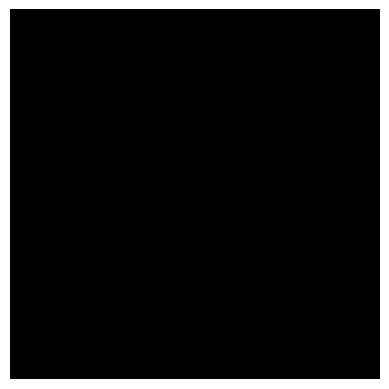

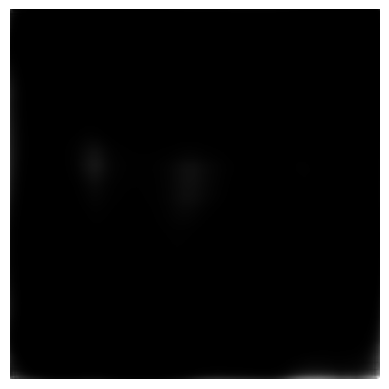

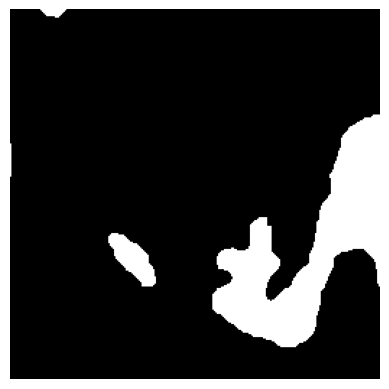

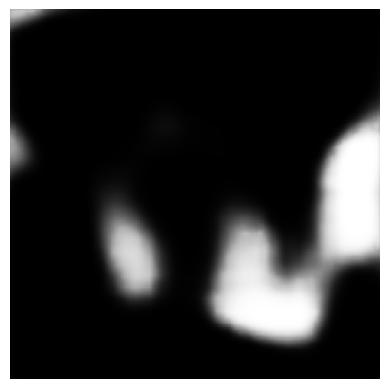

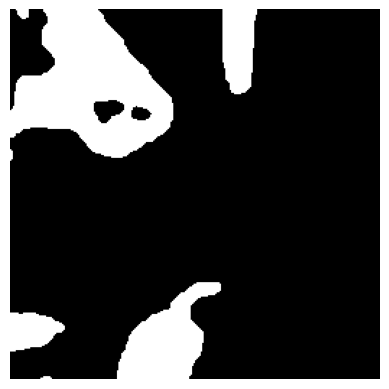

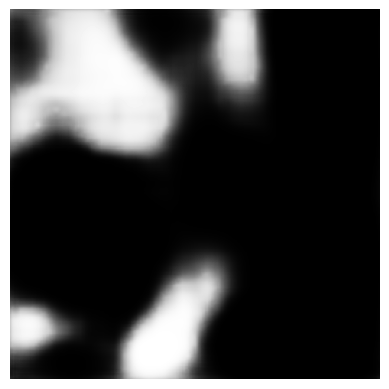

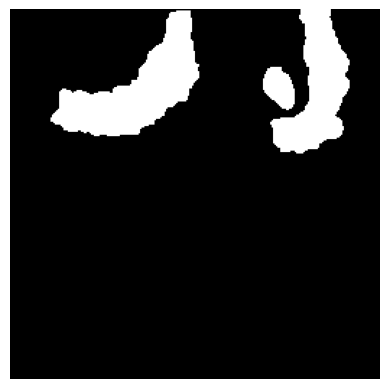

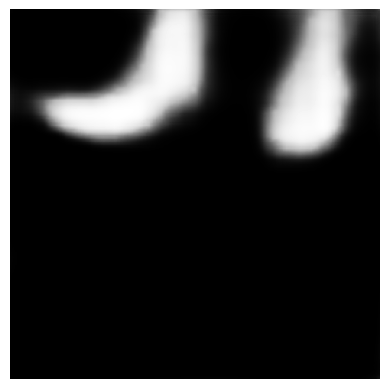

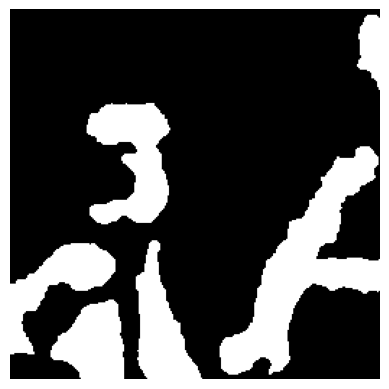

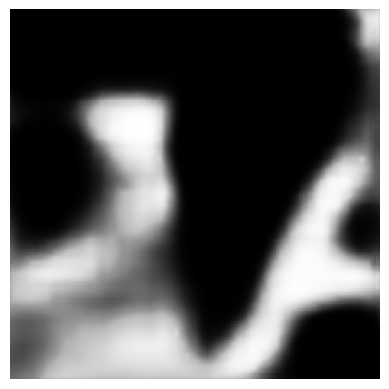

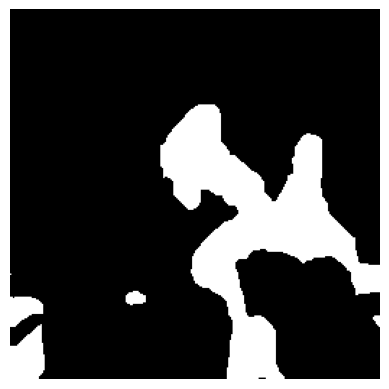

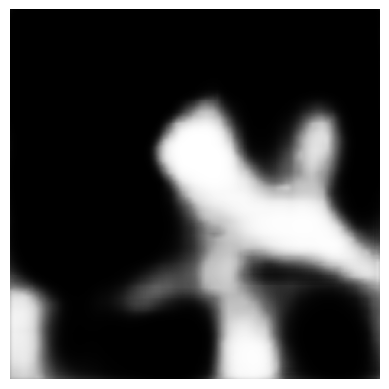

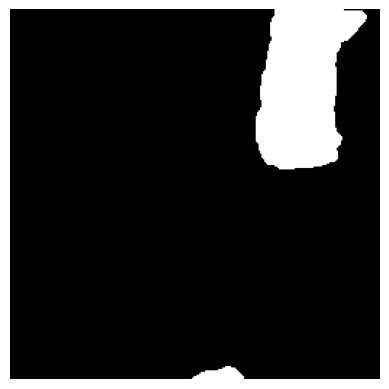

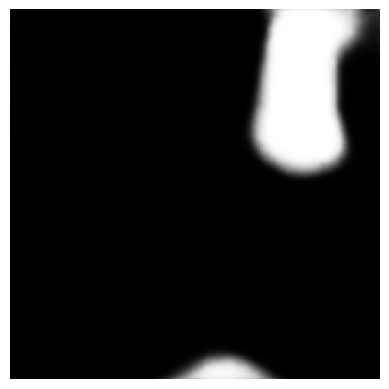

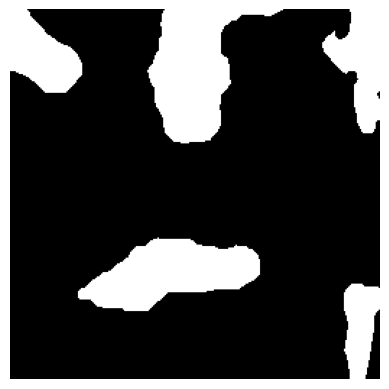

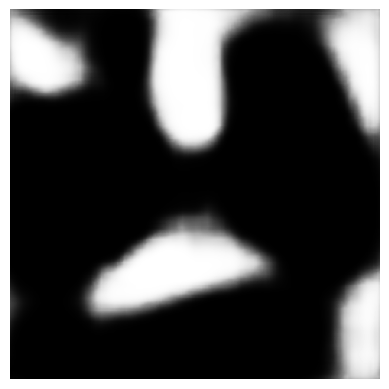

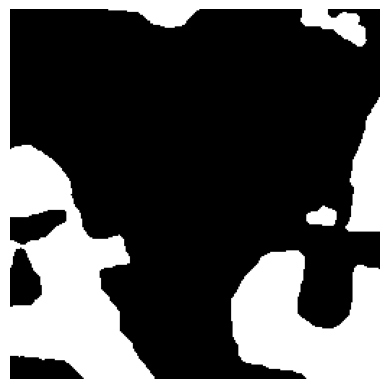

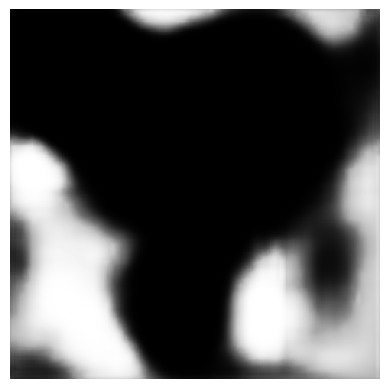

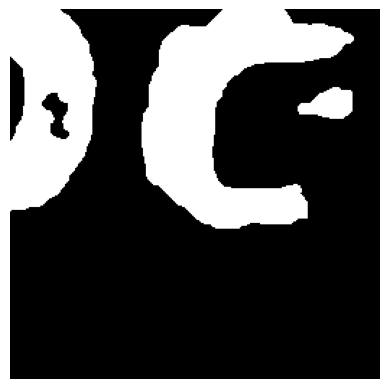

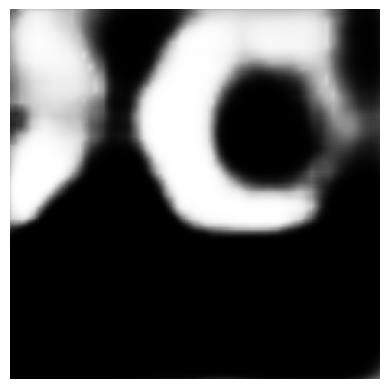

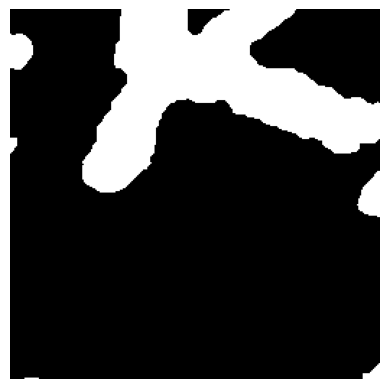

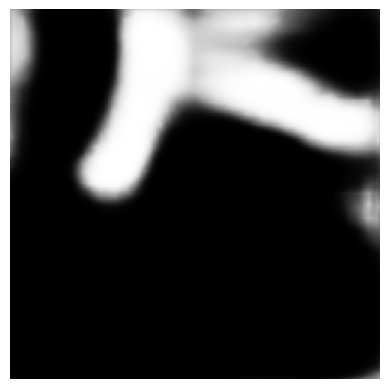

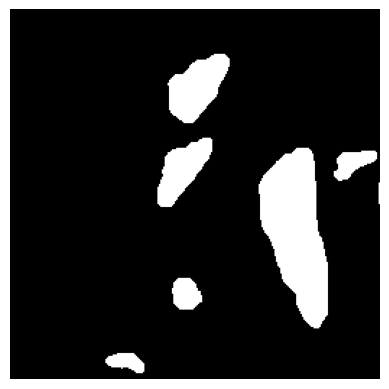

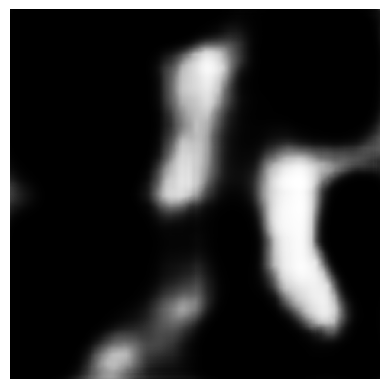

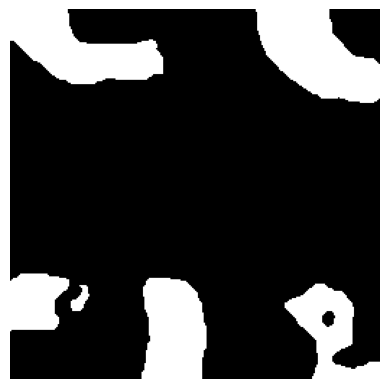

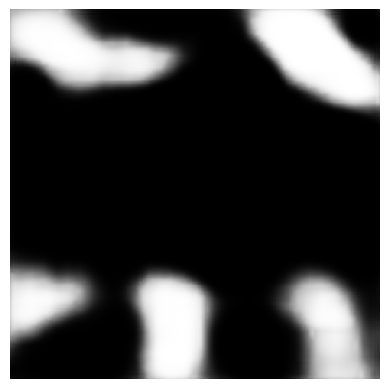

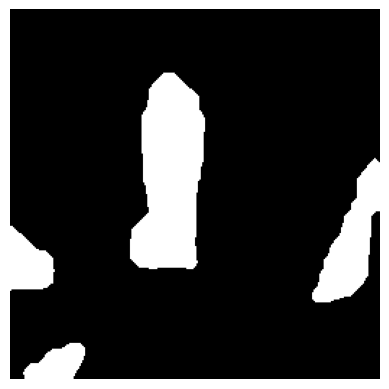

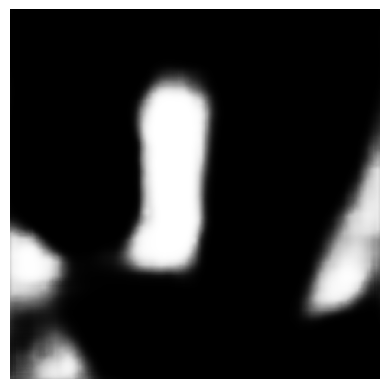

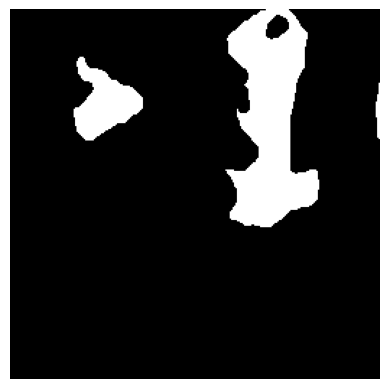

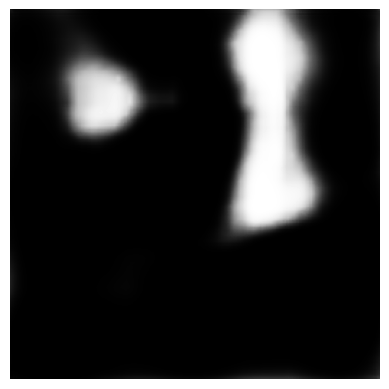

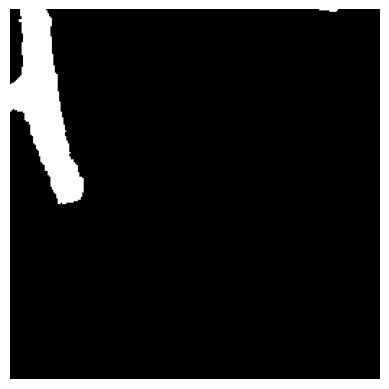

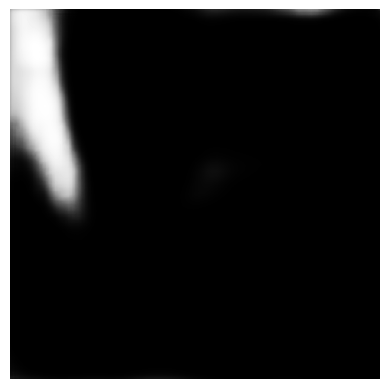

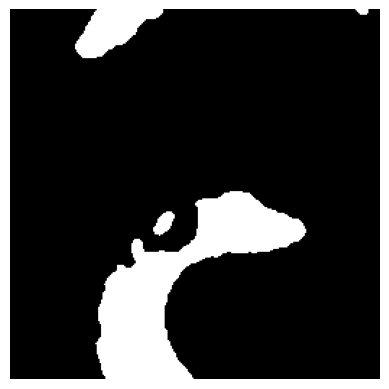

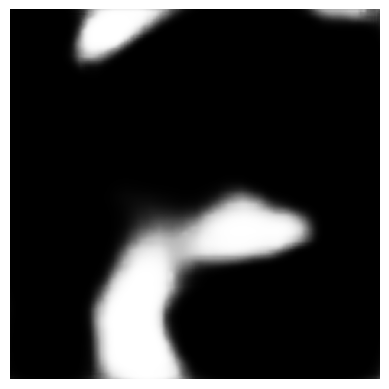

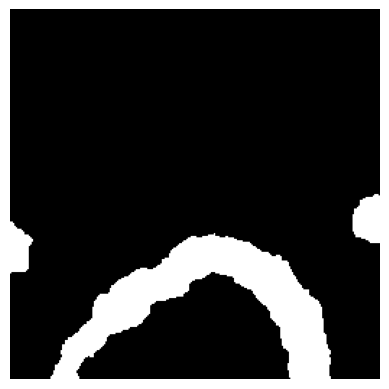

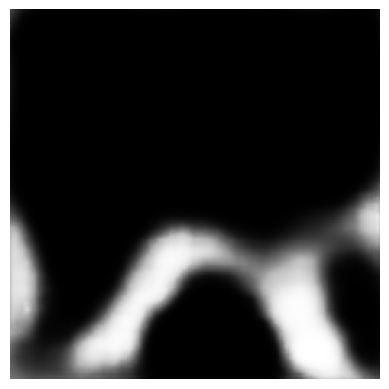

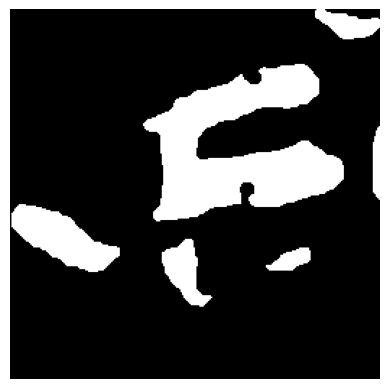

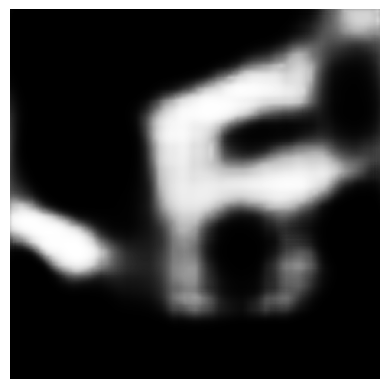

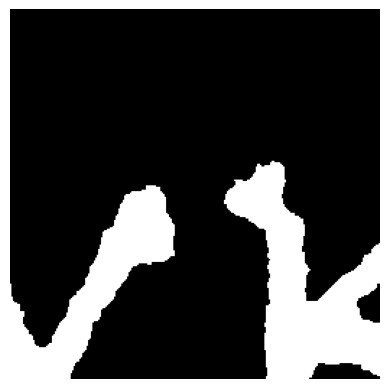

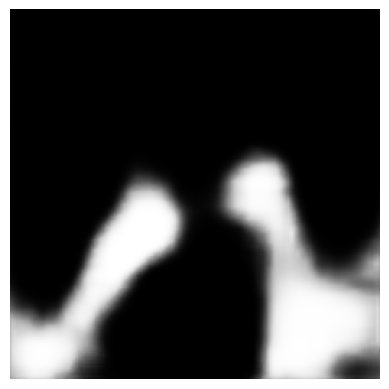

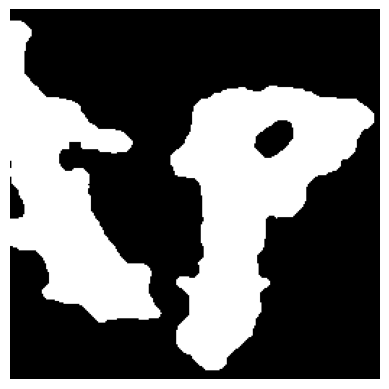

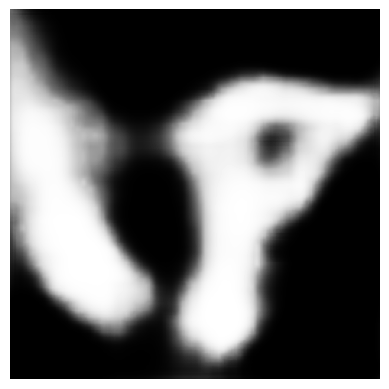

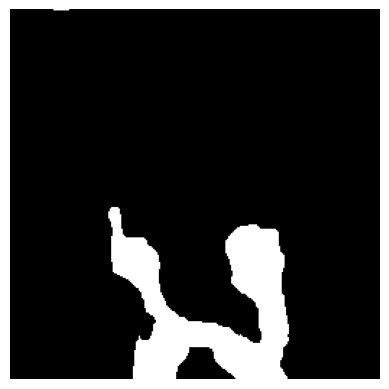

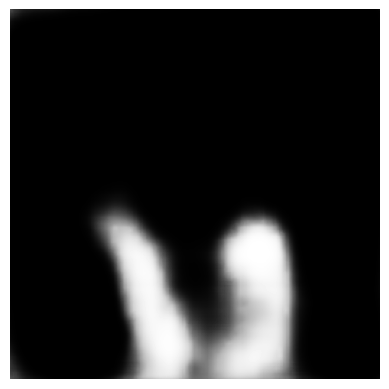

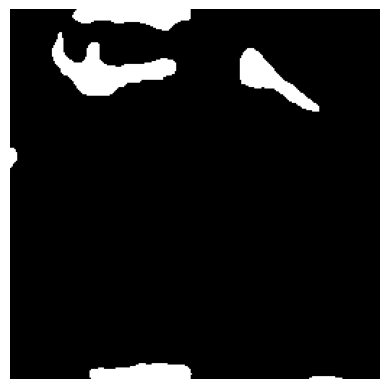

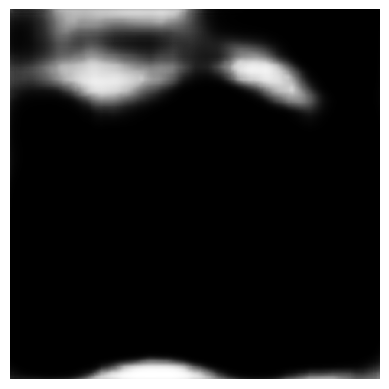

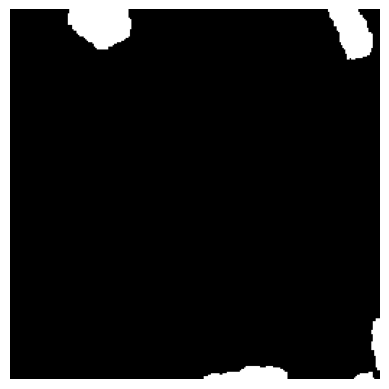

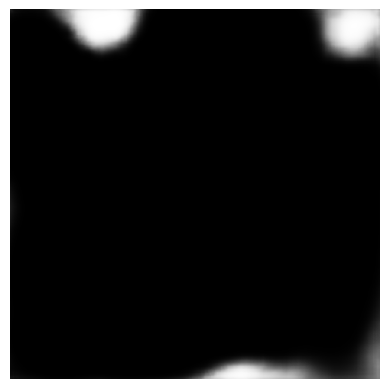

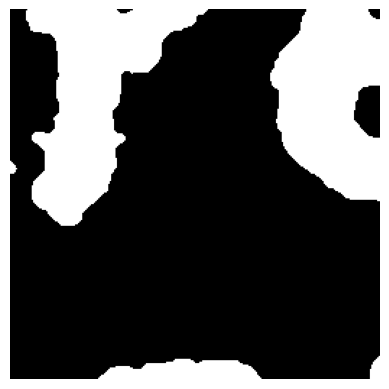

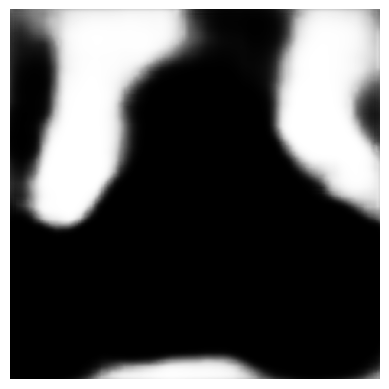

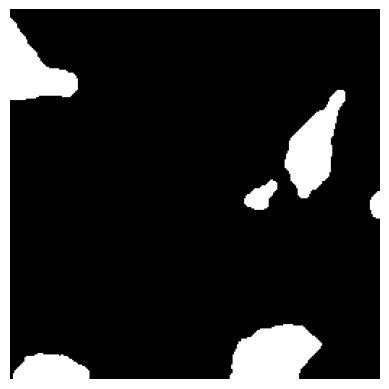

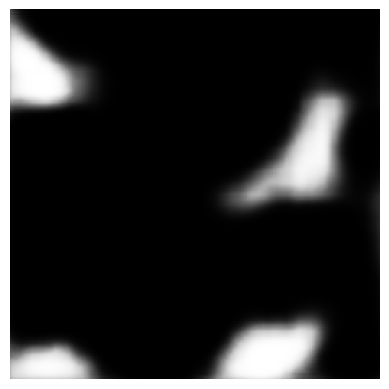

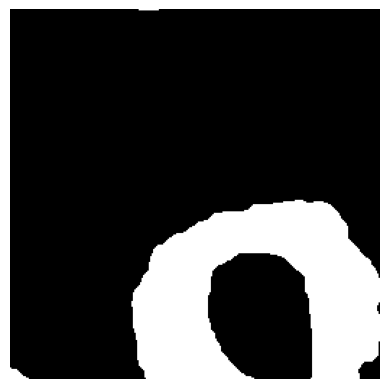

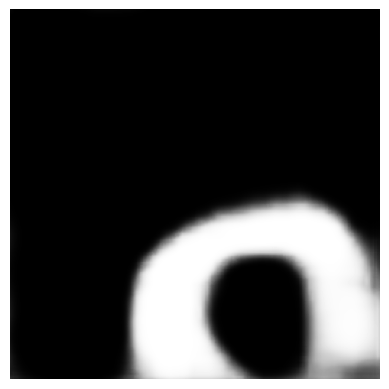

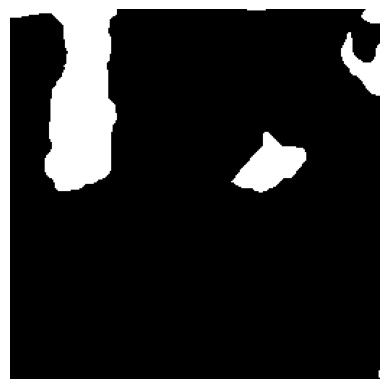

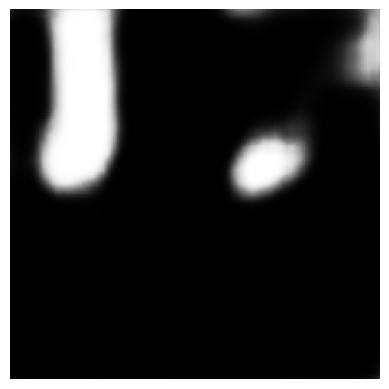

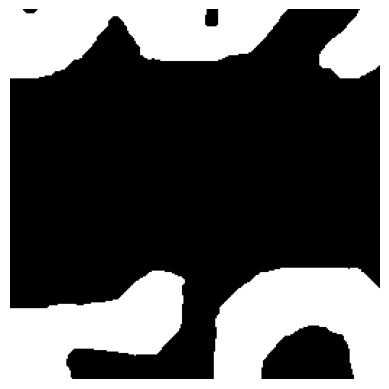

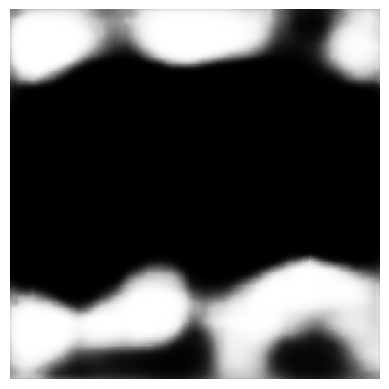

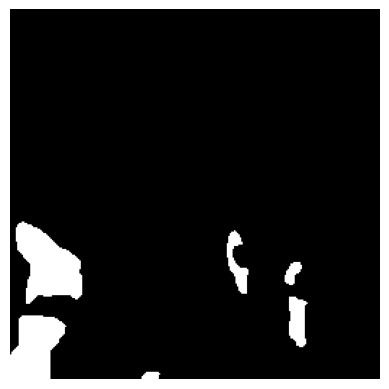

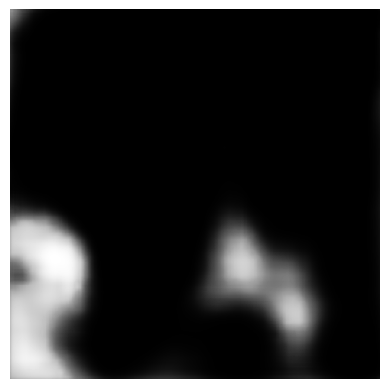

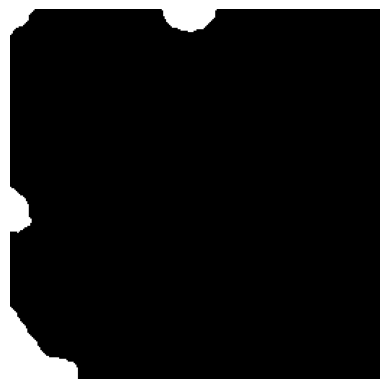

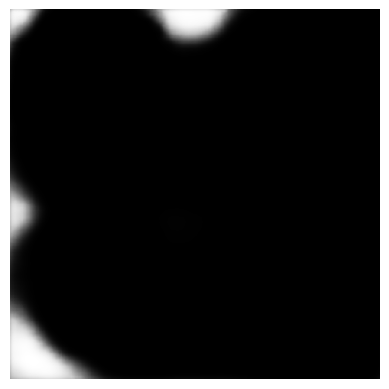

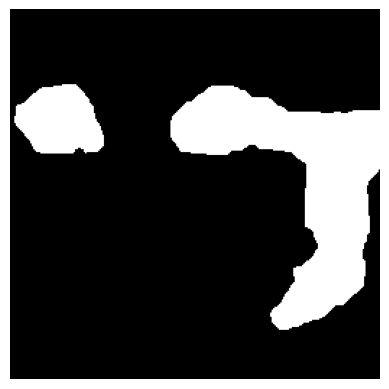

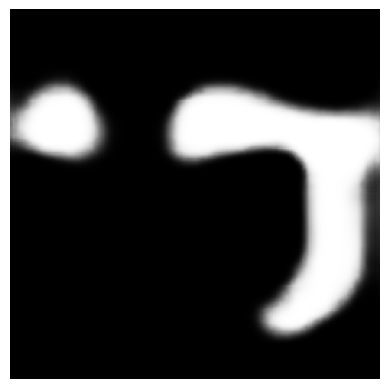

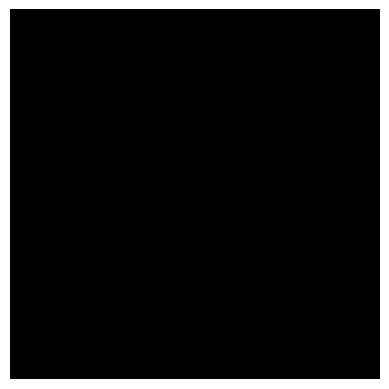

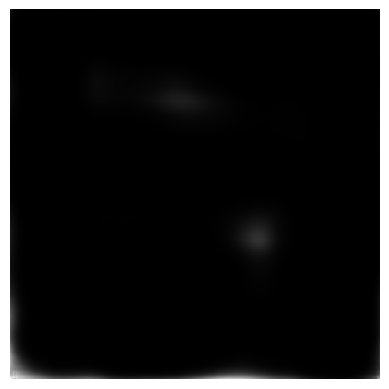

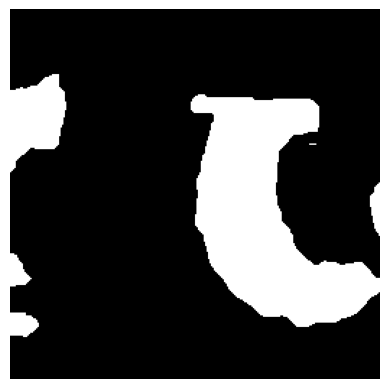

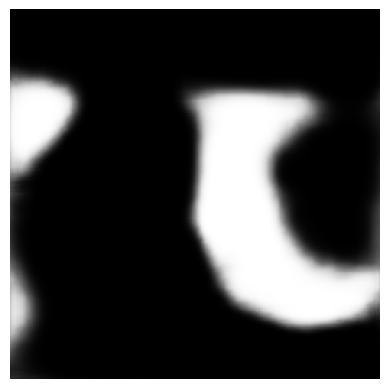

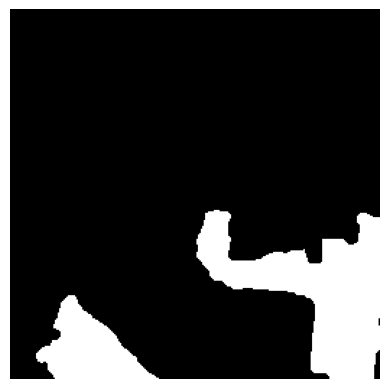

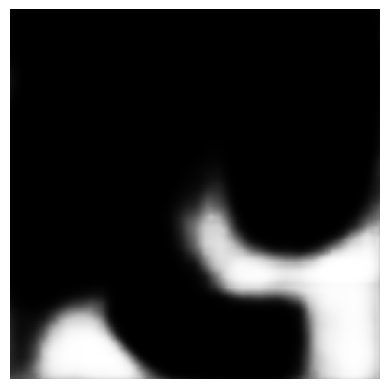

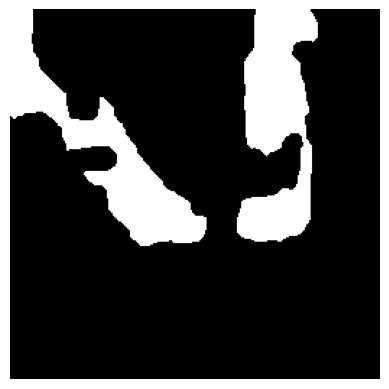

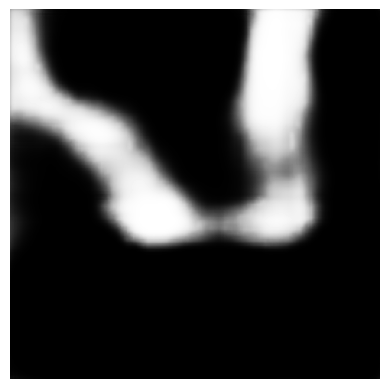

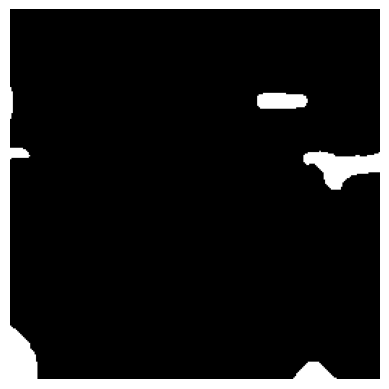

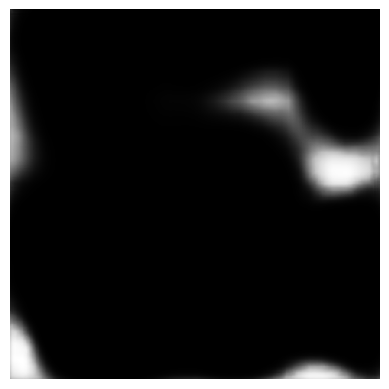

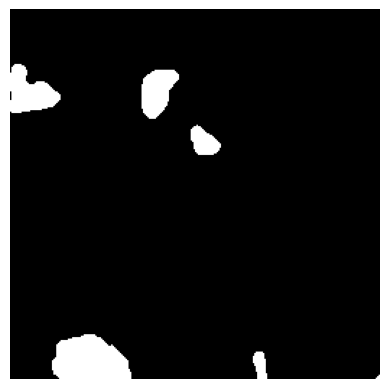

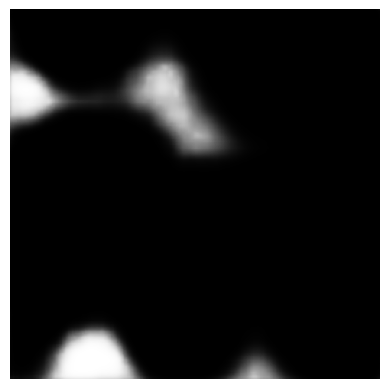

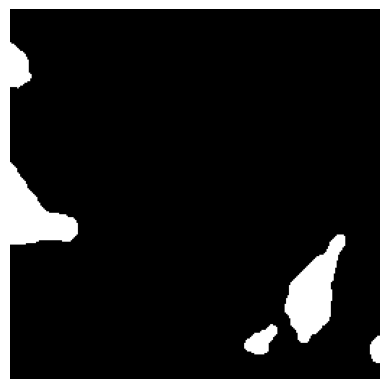

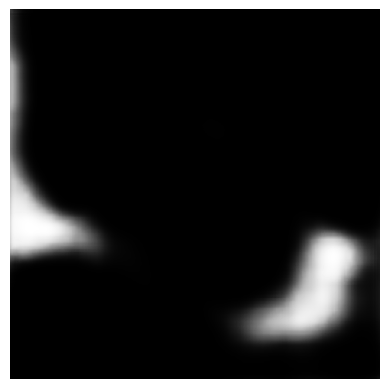

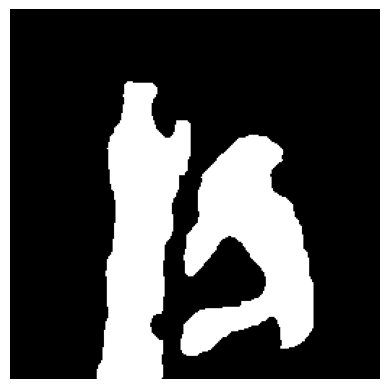

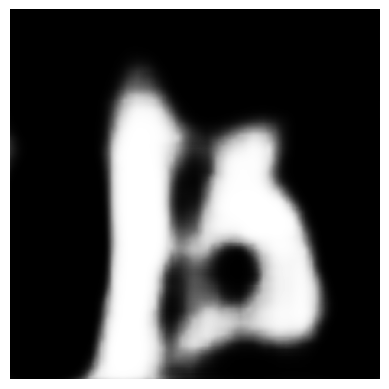

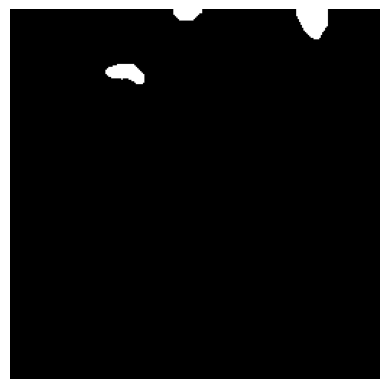

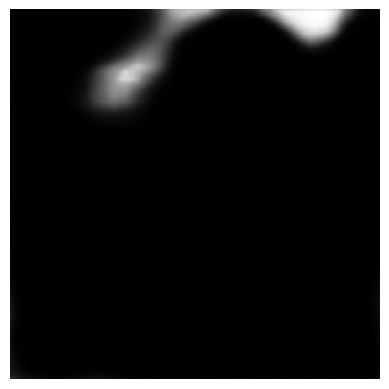

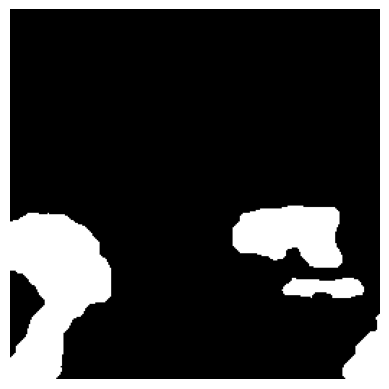

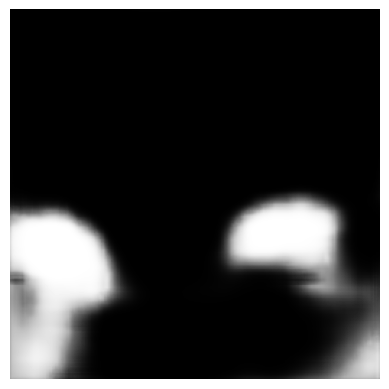

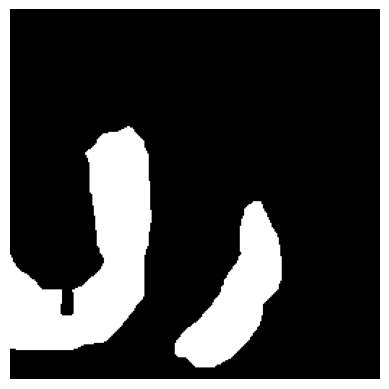

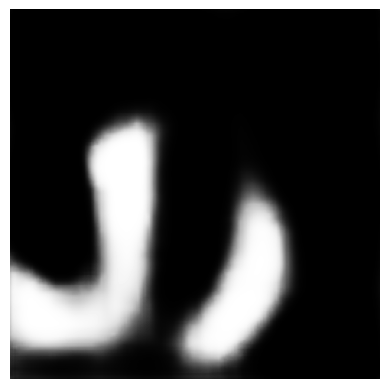

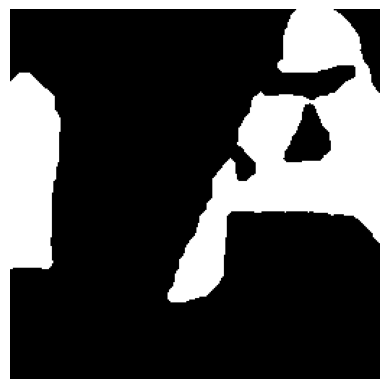

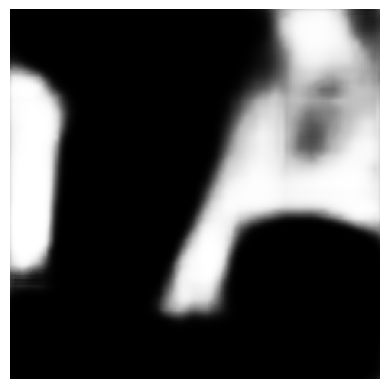

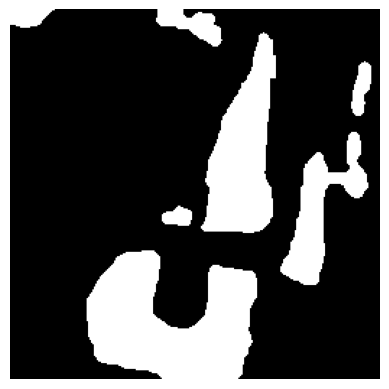

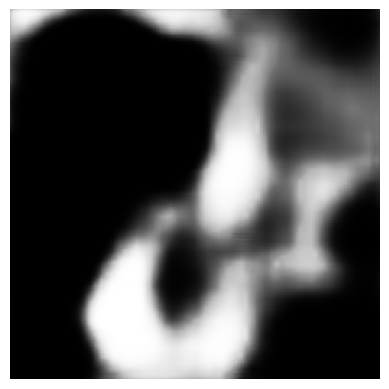

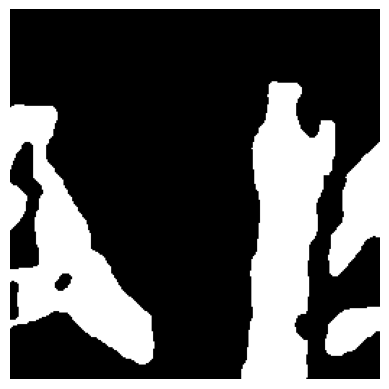

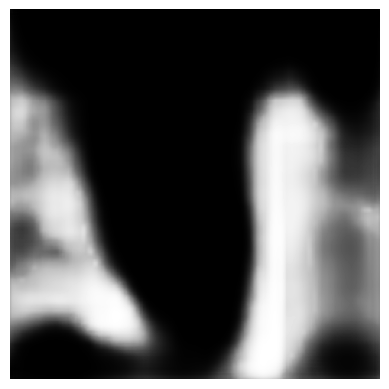

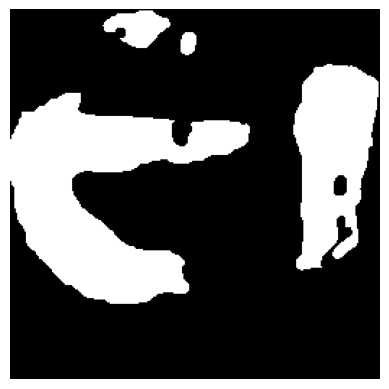

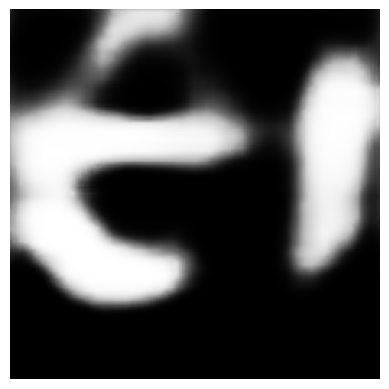

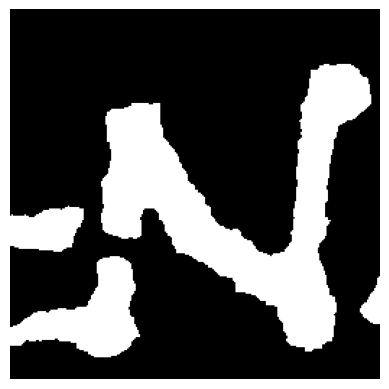

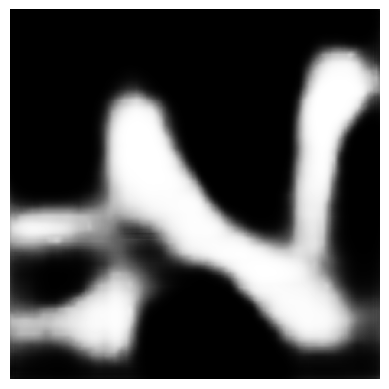

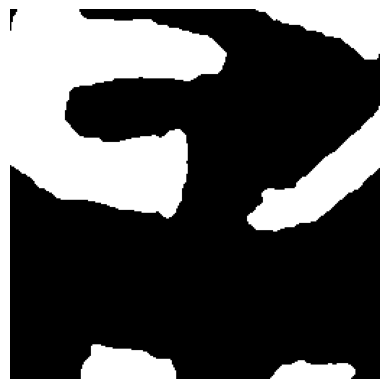

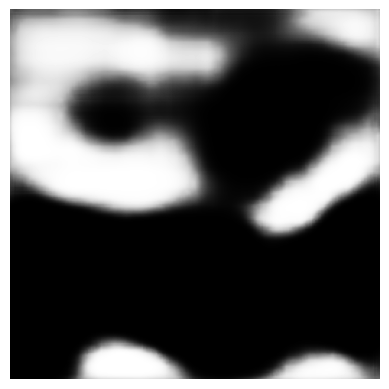

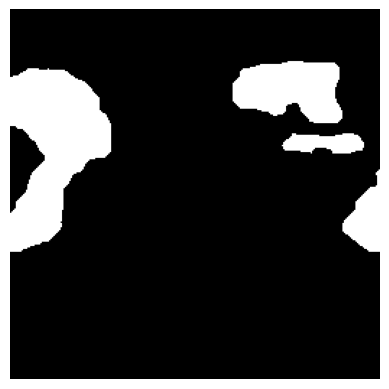

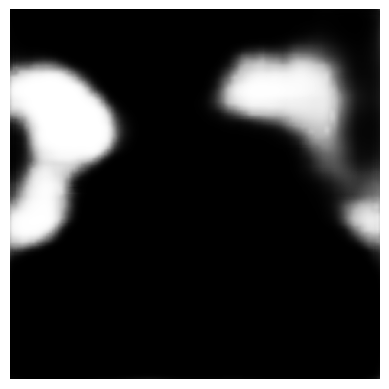

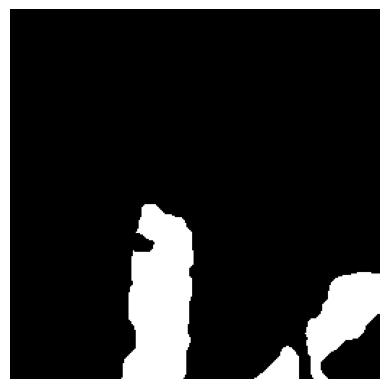

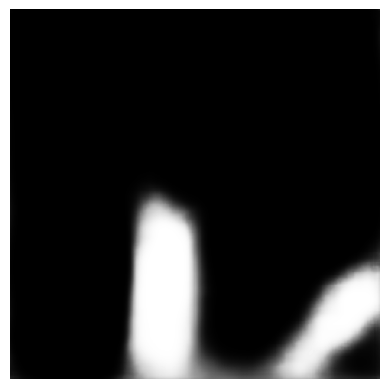

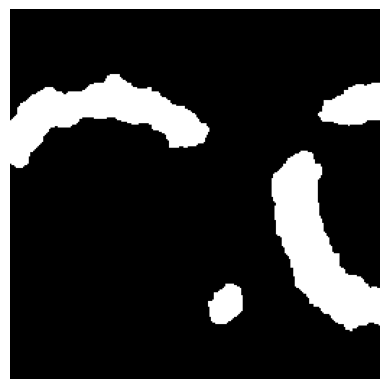

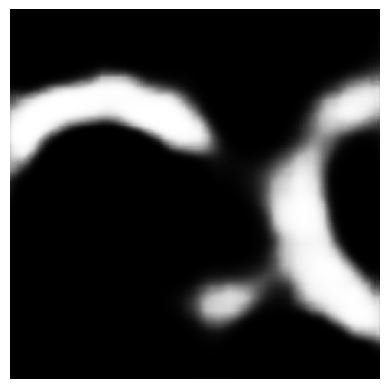

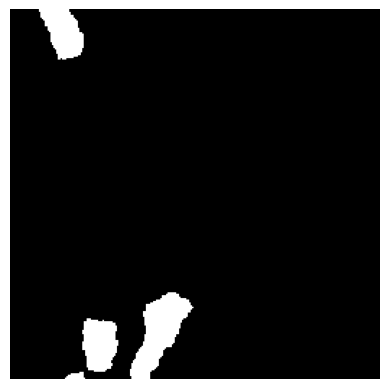

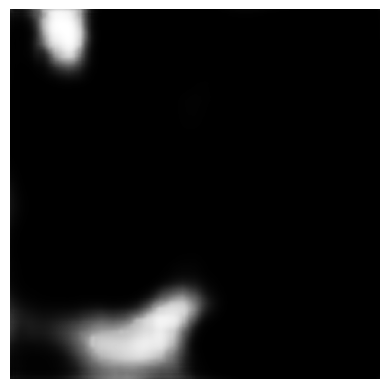

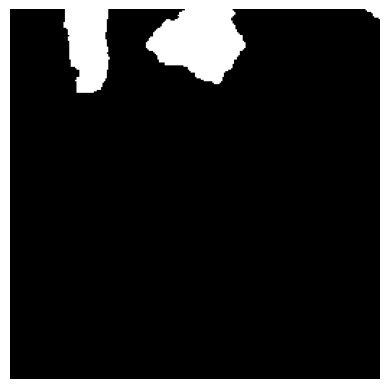

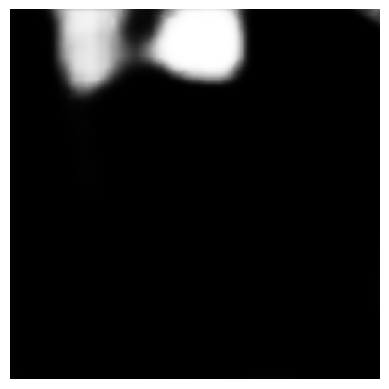

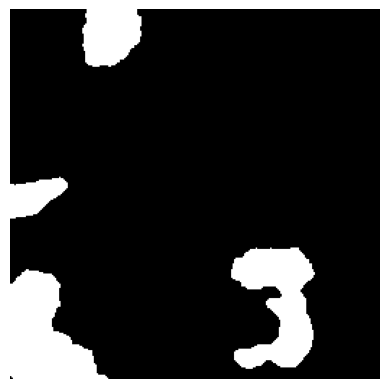

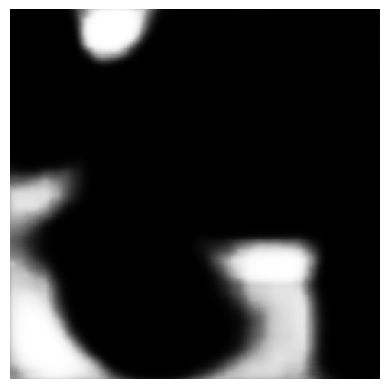

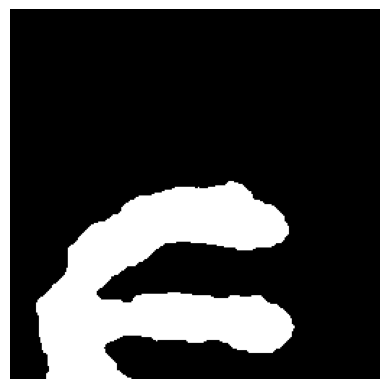

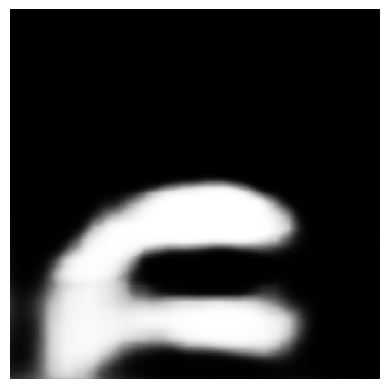

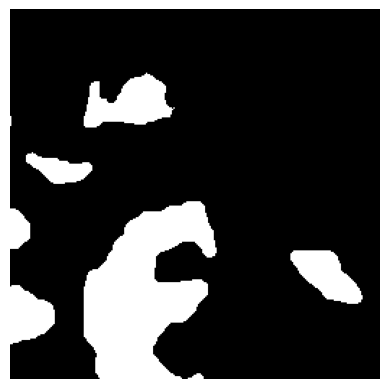

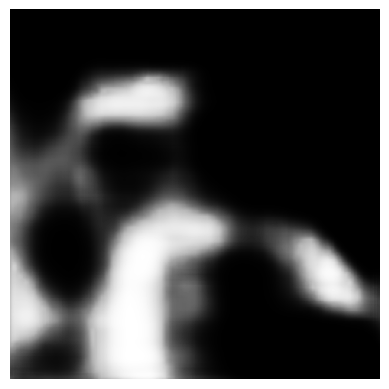

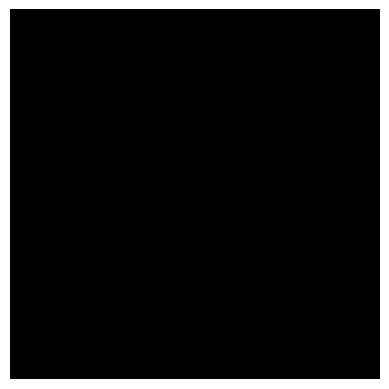

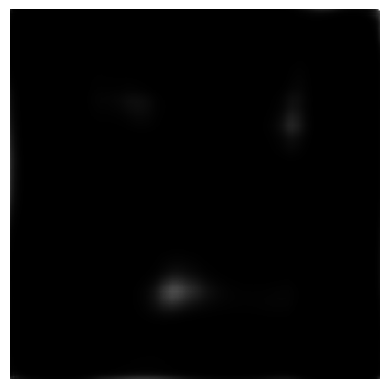

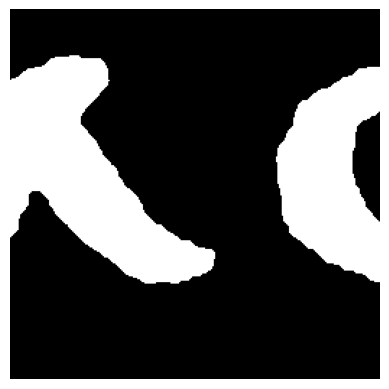

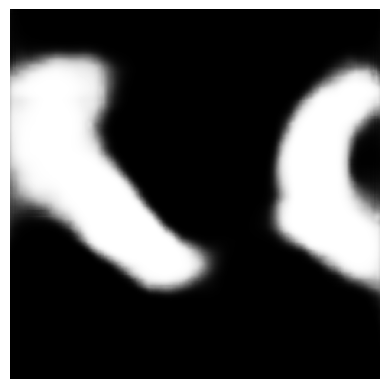

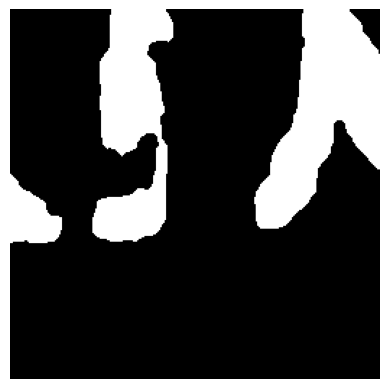

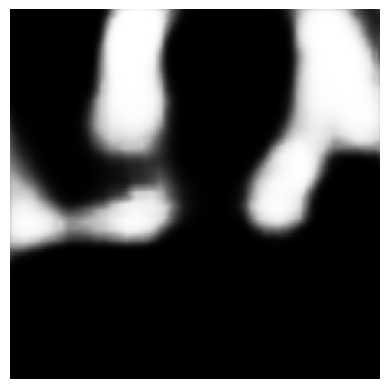

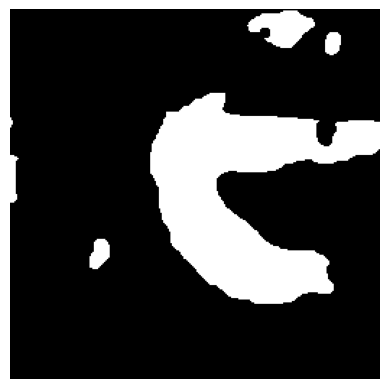

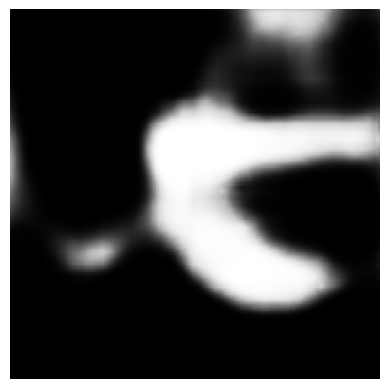

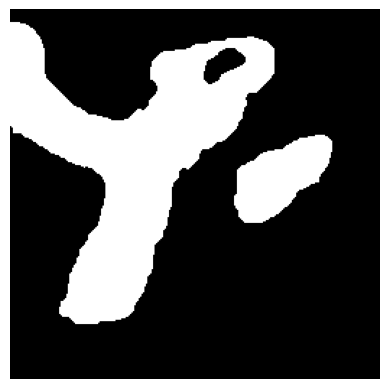

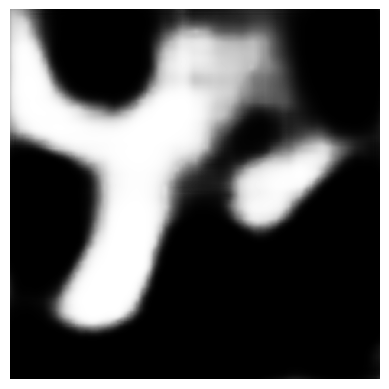

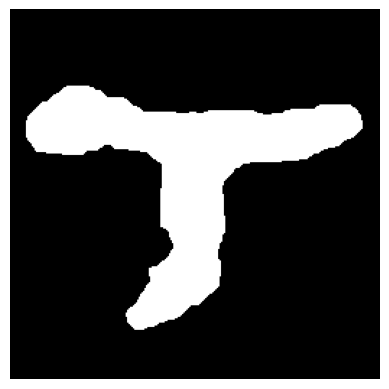

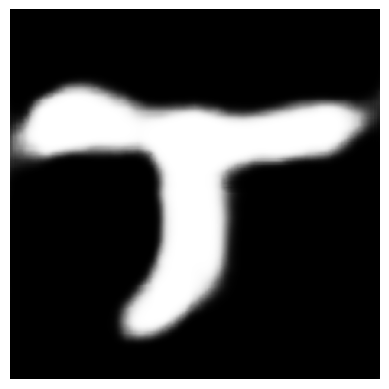

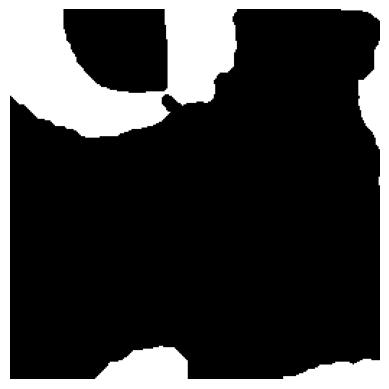

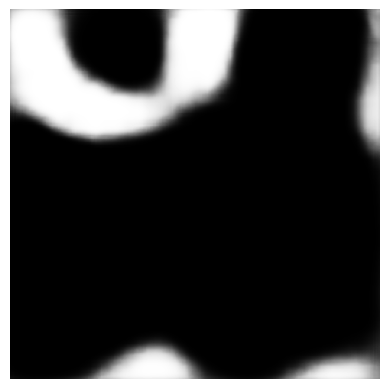

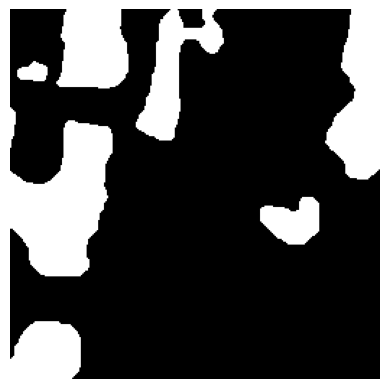

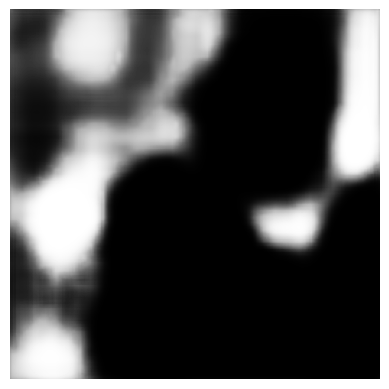

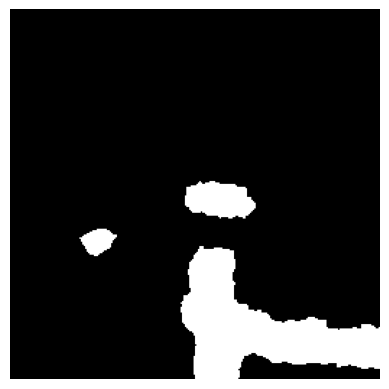

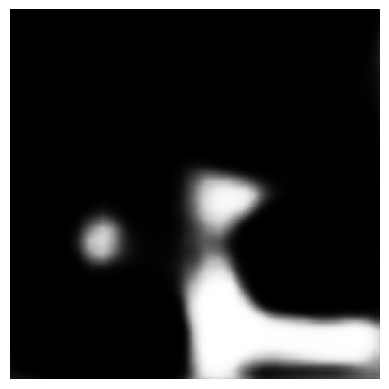

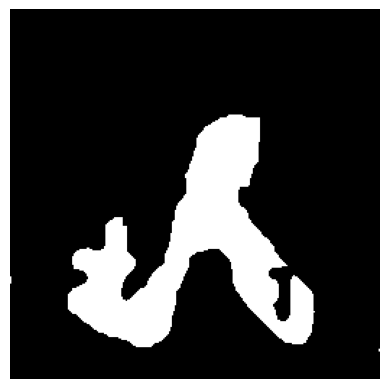

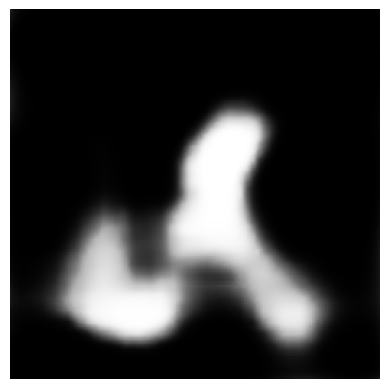

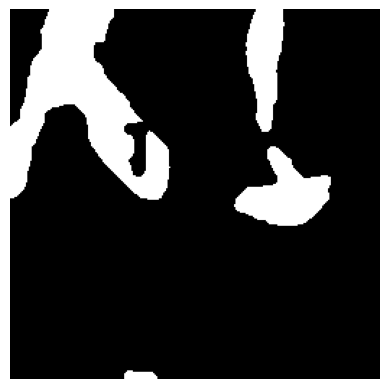

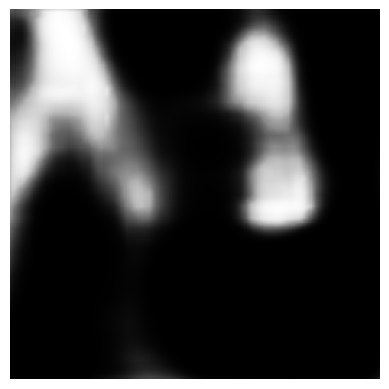

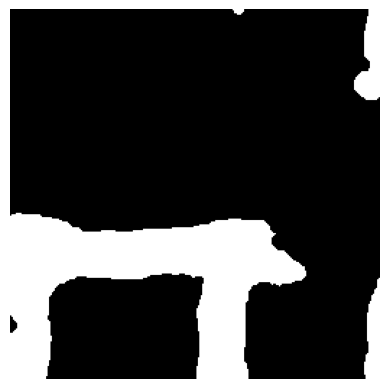

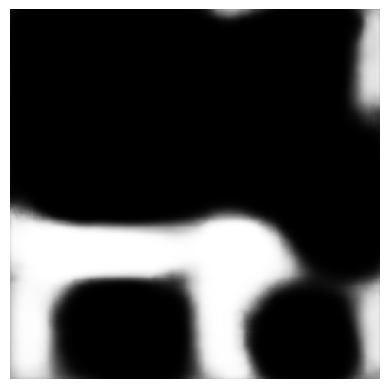

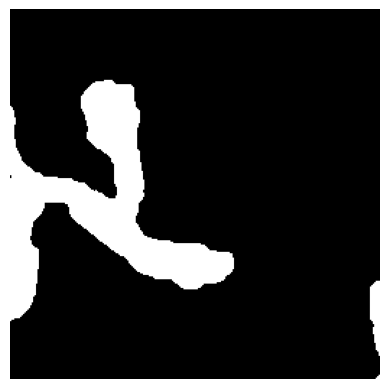

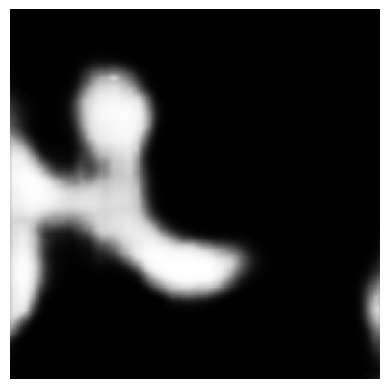

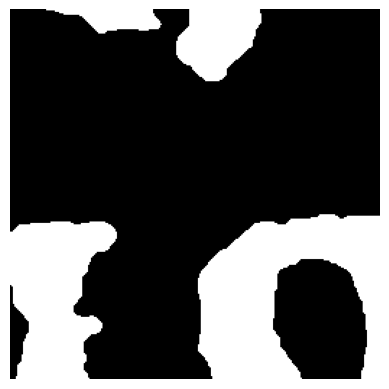

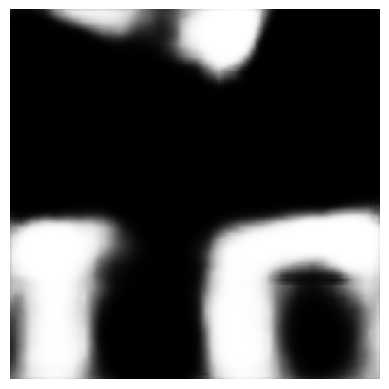

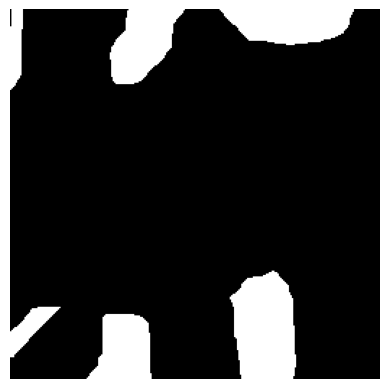

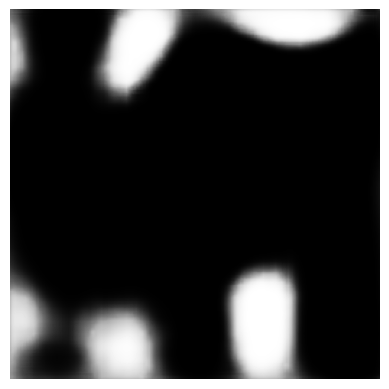

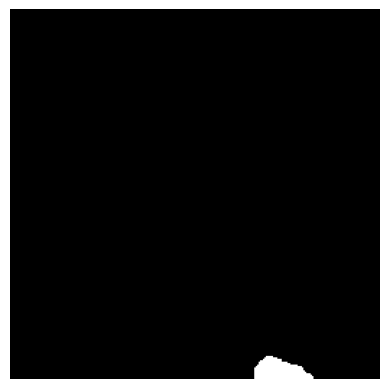

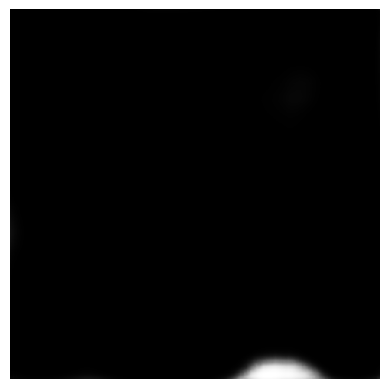

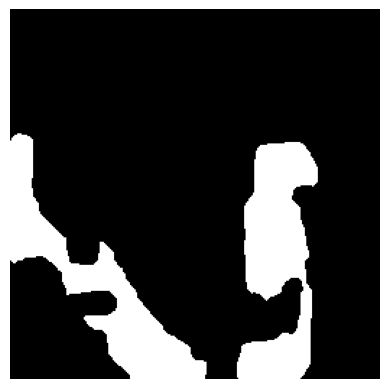

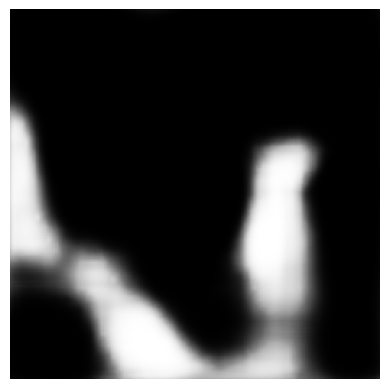

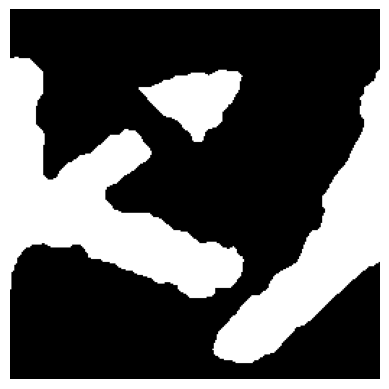

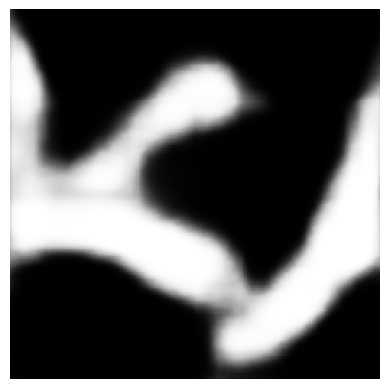

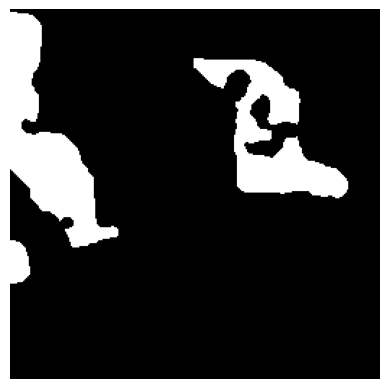

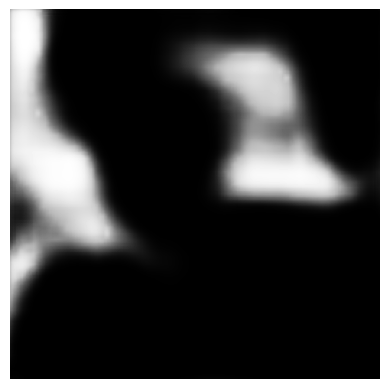

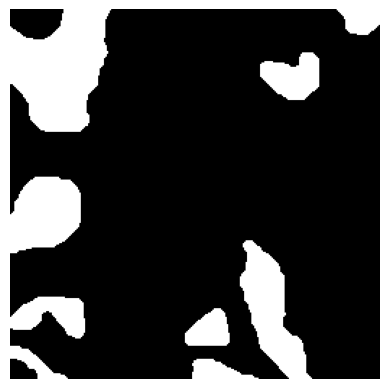

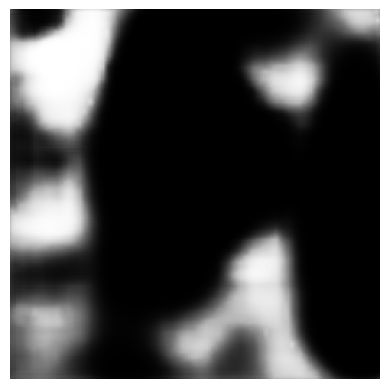

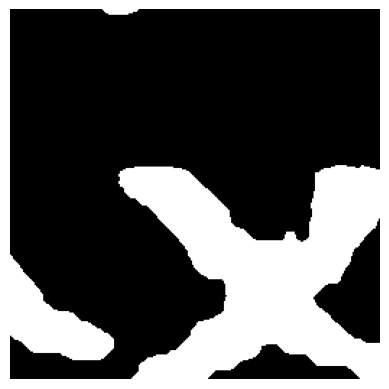

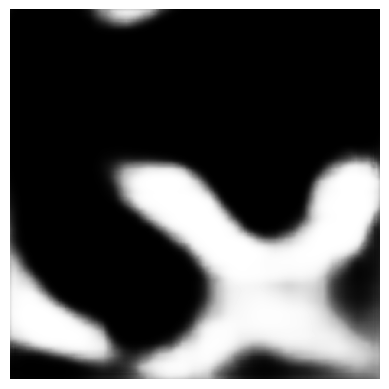

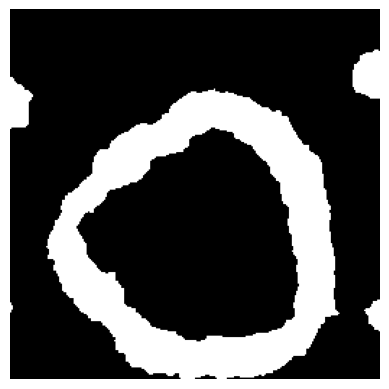

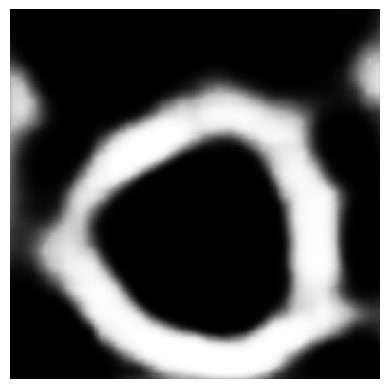

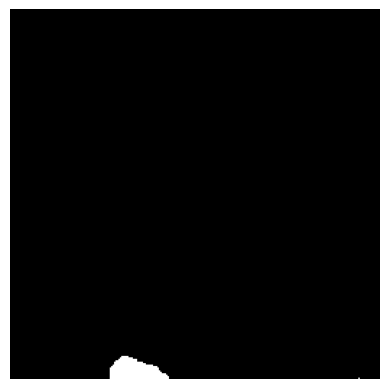

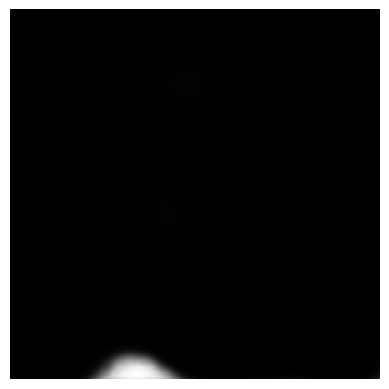

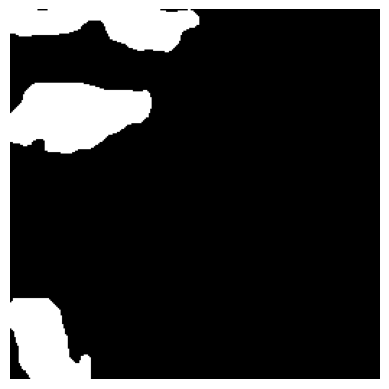

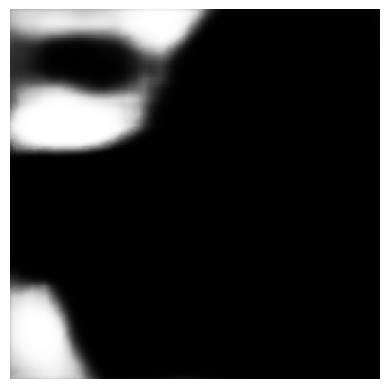

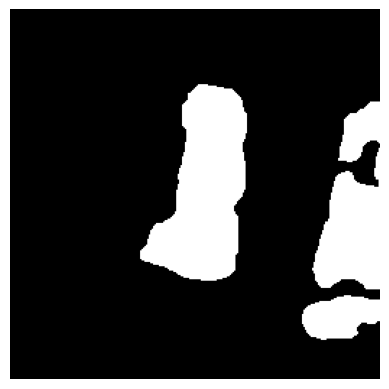

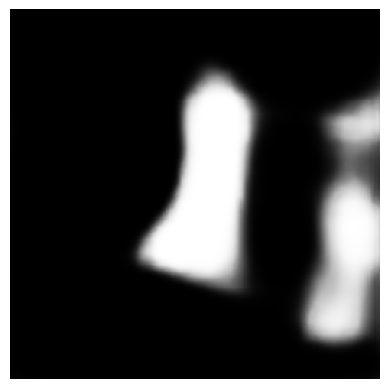

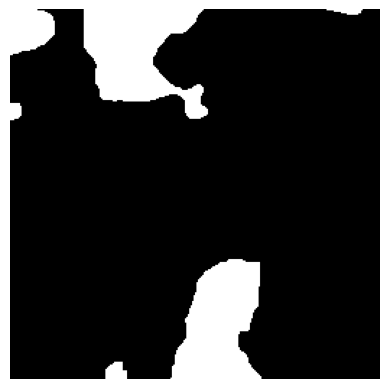

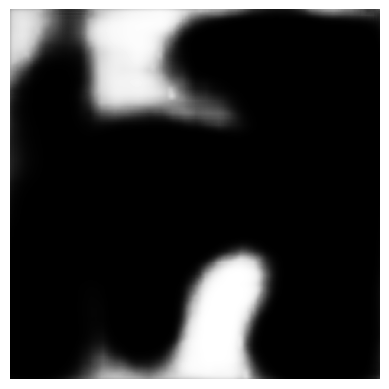

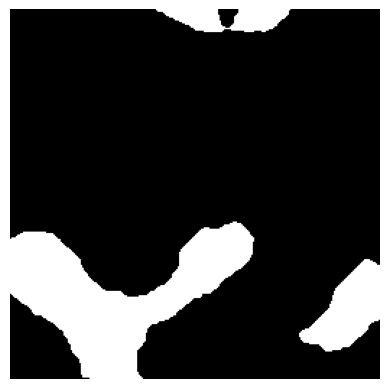

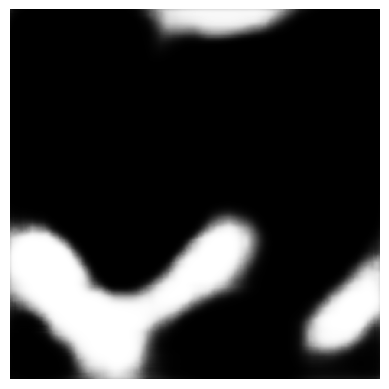

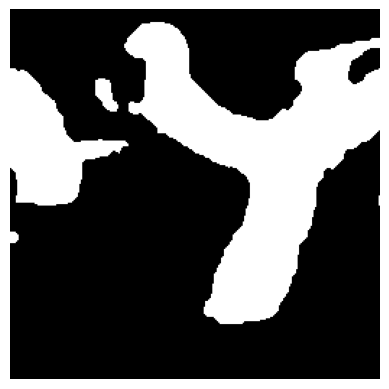

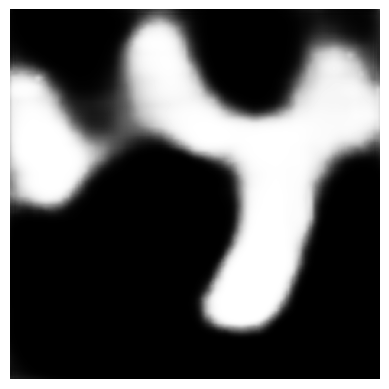

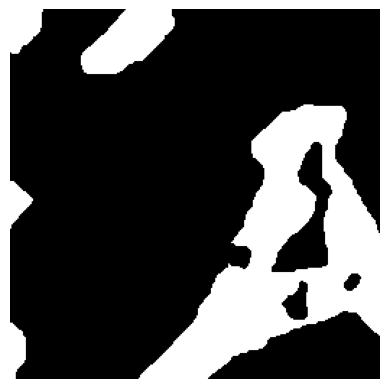

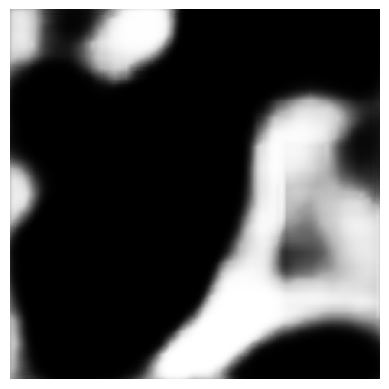

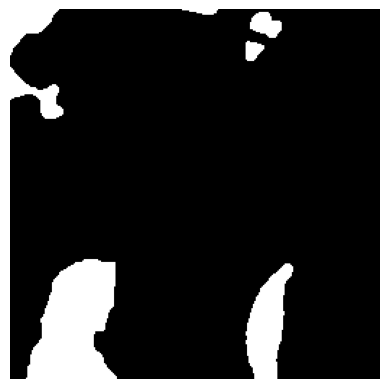

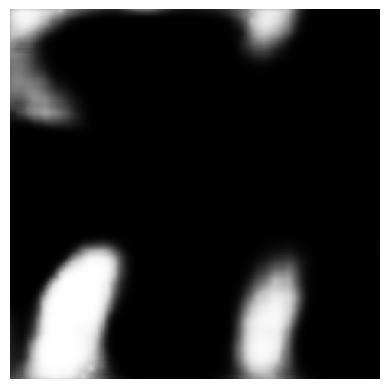

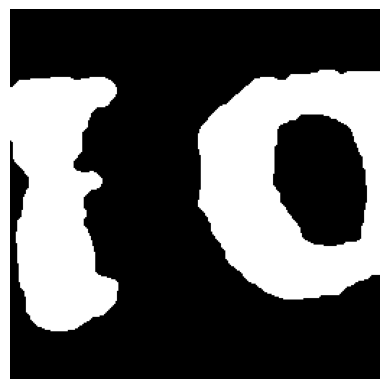

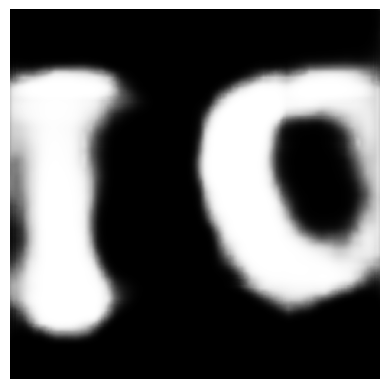

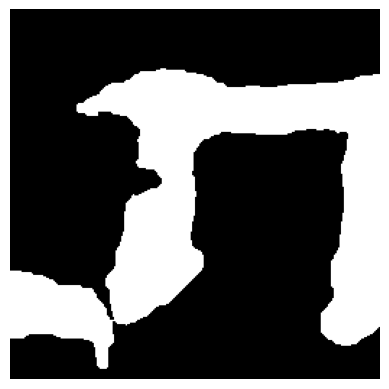

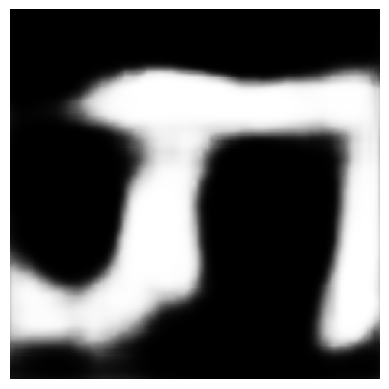

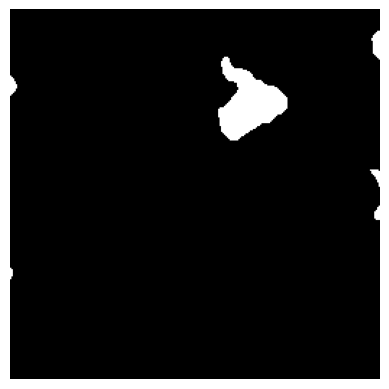

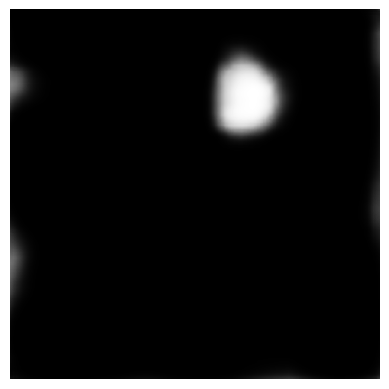

In [23]:
outputs_np = []
for result in results_test:
    # Convert the PyTorch tensor to a NumPy array
    outputs_np.append(result.cpu().numpy())

# Iterate over the outputs
for i in range(len(outputs_np)):
    output = outputs_np[i][0][0]

    # Display the output as an image
    plt.imshow(output, cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    plt.show()

In [24]:
model = torch.load('../models/ink_detection_256_upsample_u_net_middle_layer_epoch_150_batch_16.pt')

model.eval()  # Set the model to evaluation mode

results_test = []

with torch.no_grad():
    for batch in val_loader:
        # Move the batch to the GPU if available
        img,lbl = batch
        batch = img.to(device) if torch.cuda.is_available() else batch

        # Perform inference
        outputs = model(batch)
        results_test.append(lbl)
        results_test.append(outputs)

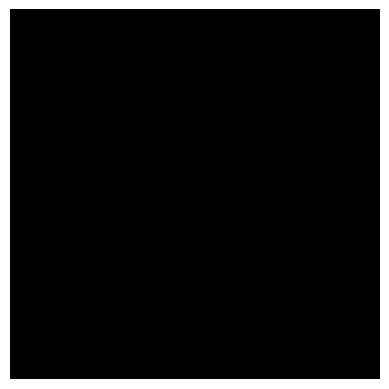

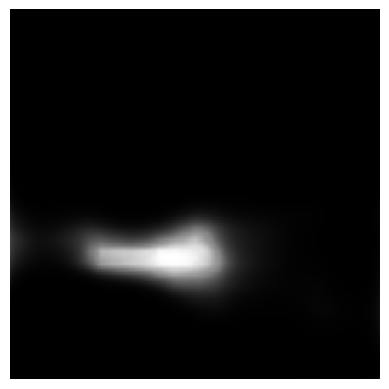

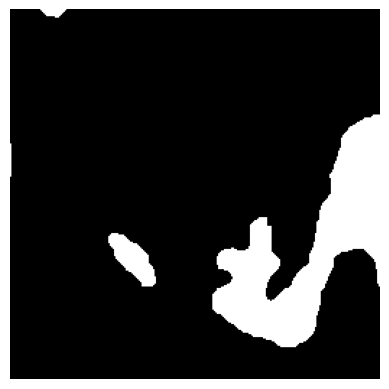

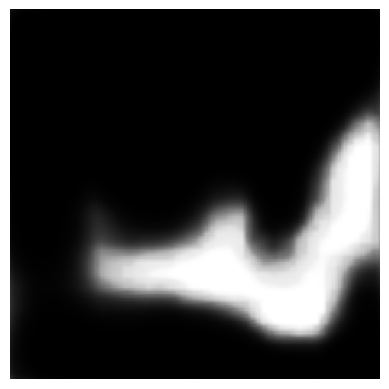

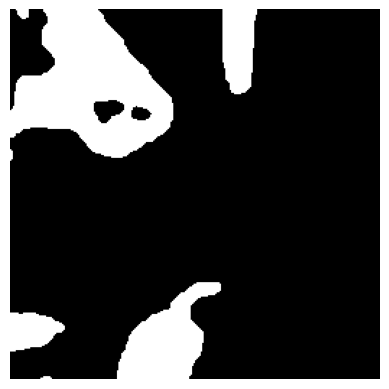

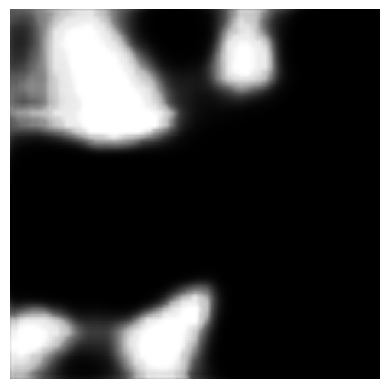

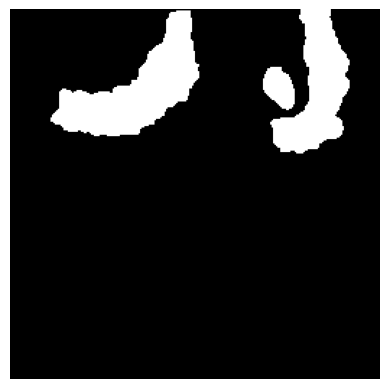

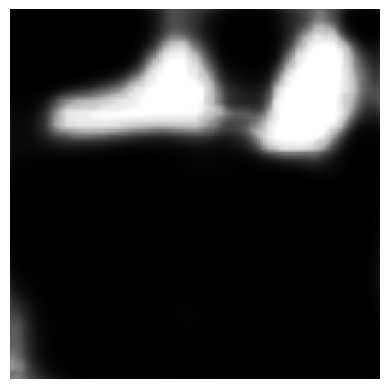

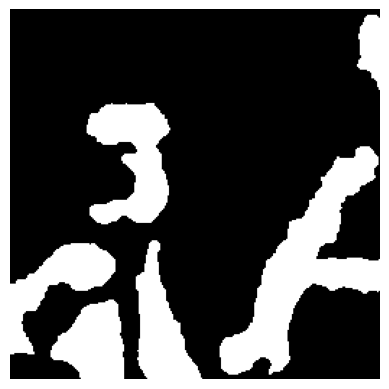

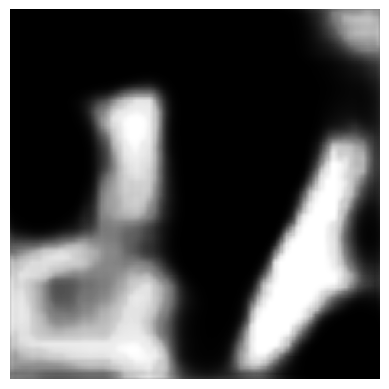

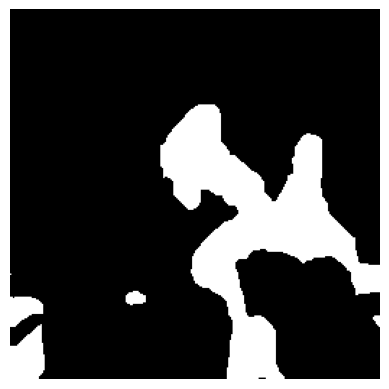

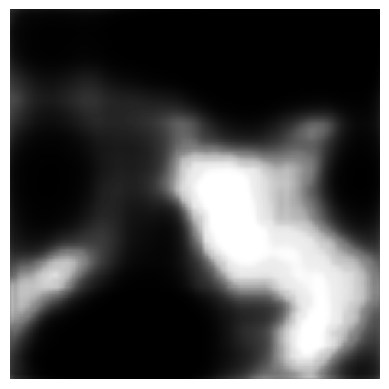

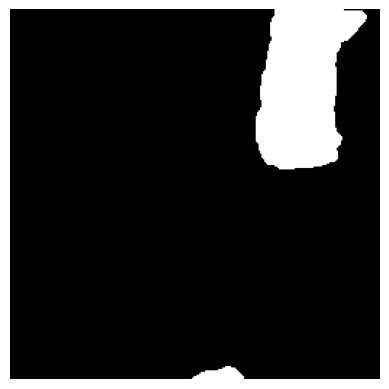

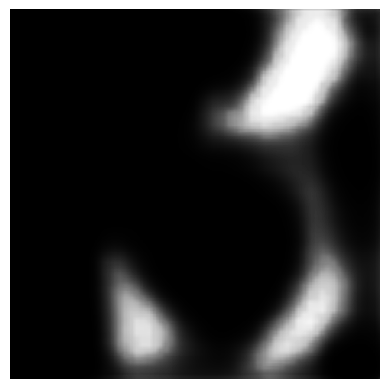

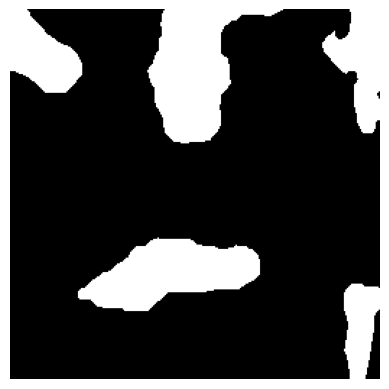

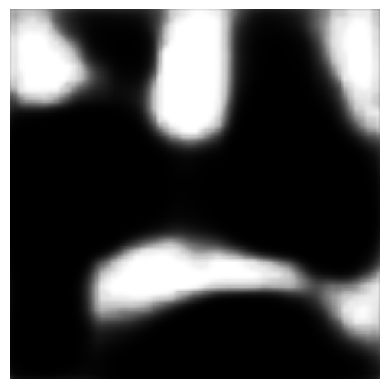

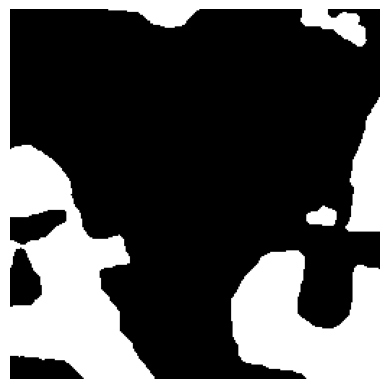

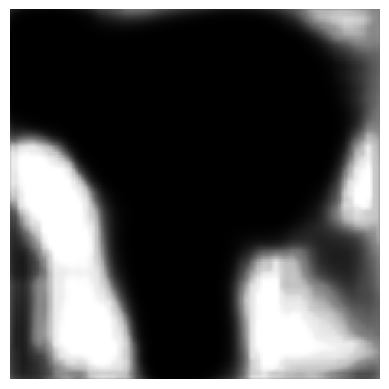

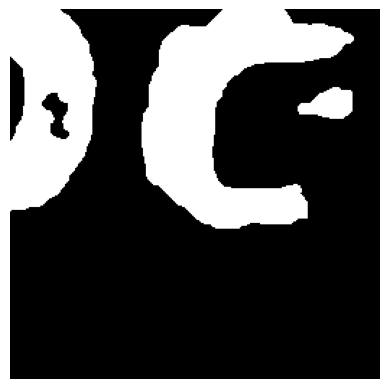

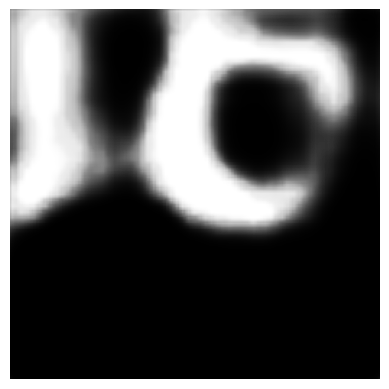

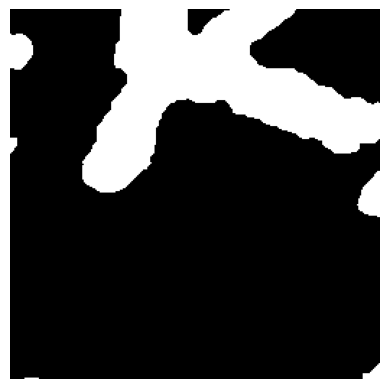

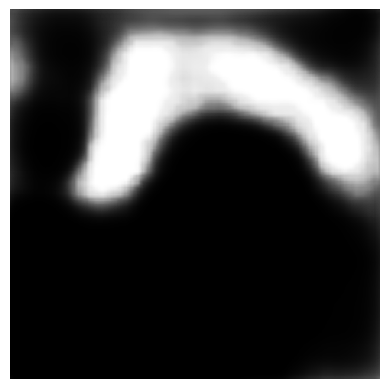

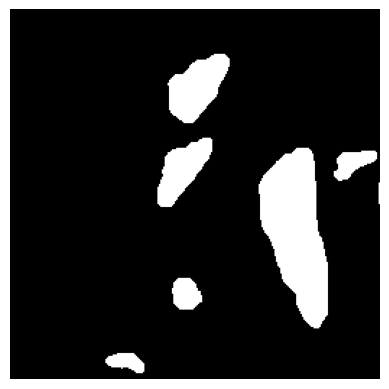

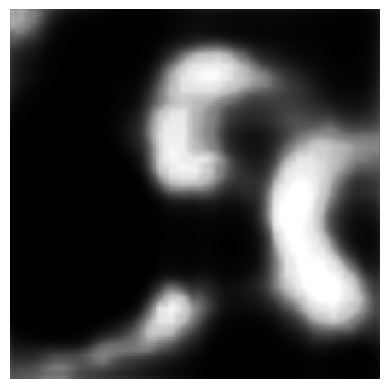

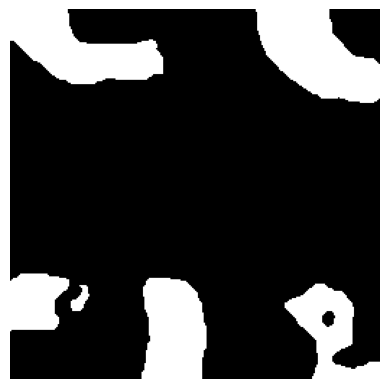

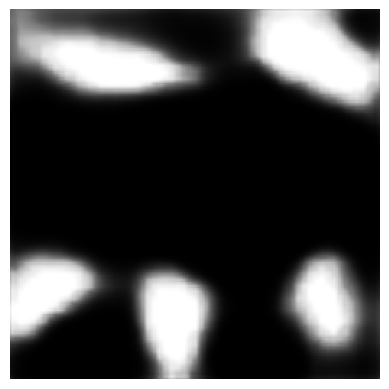

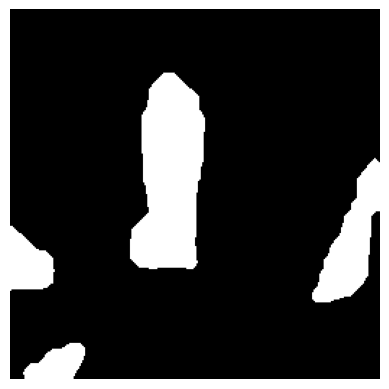

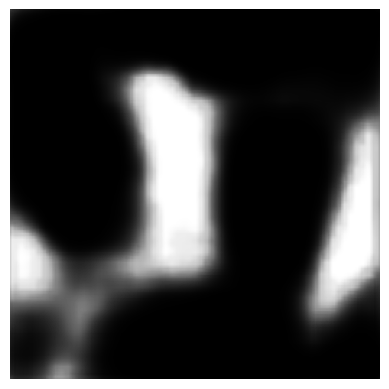

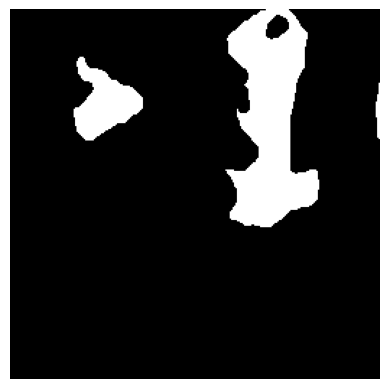

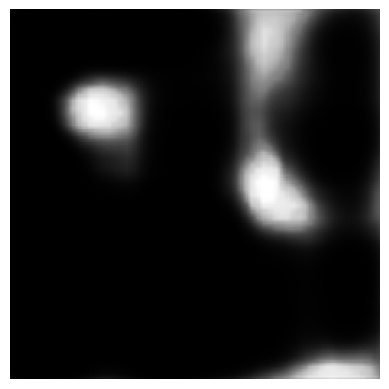

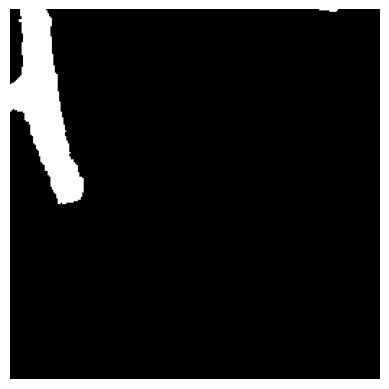

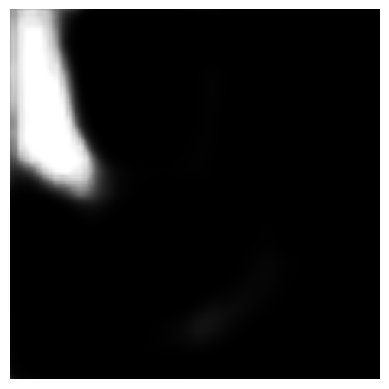

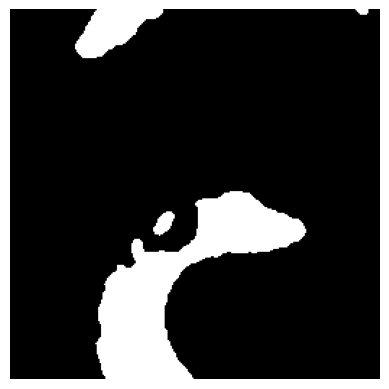

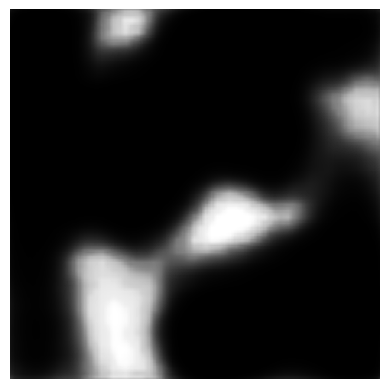

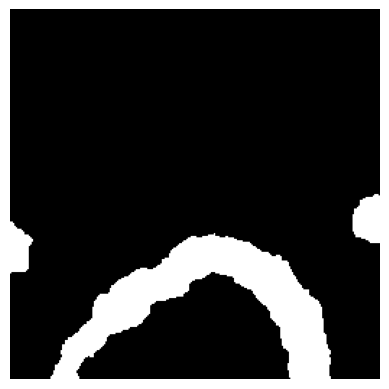

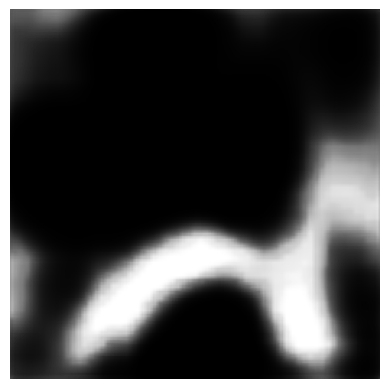

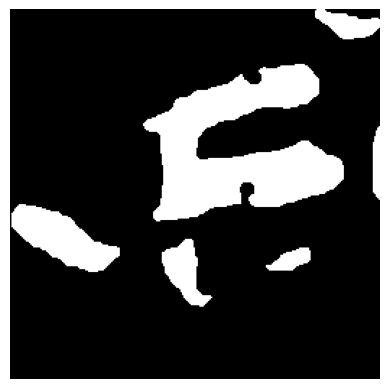

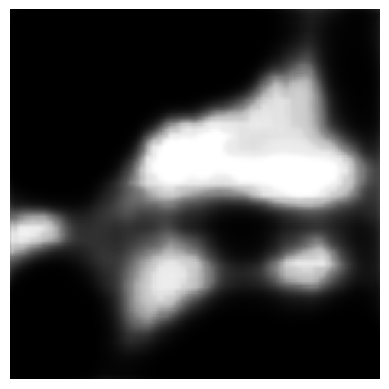

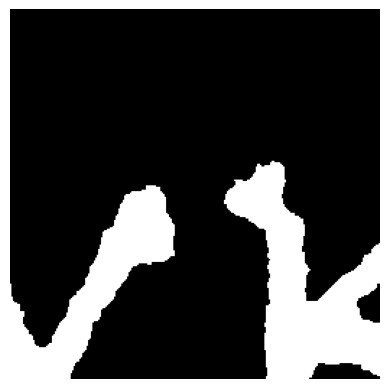

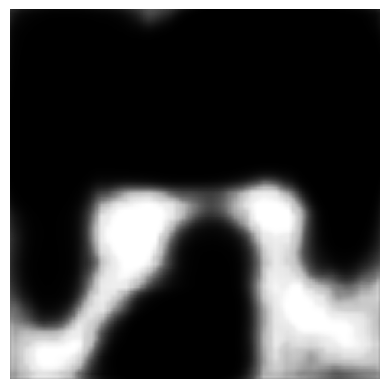

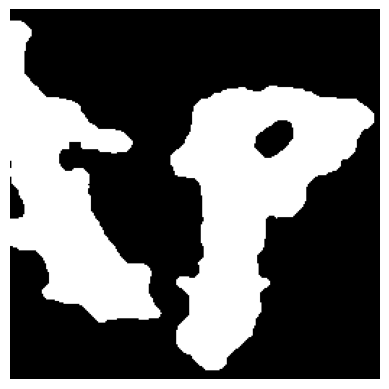

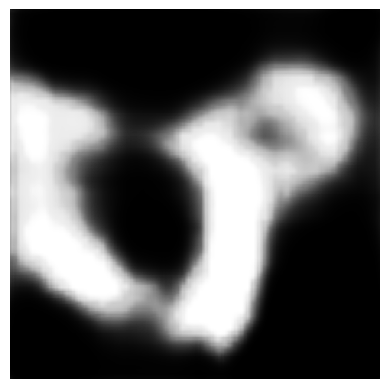

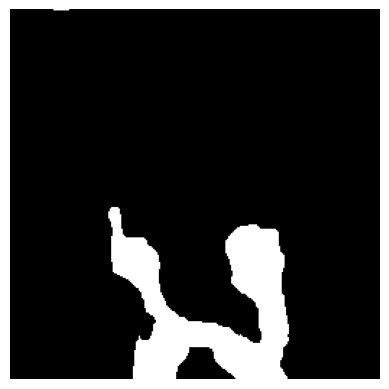

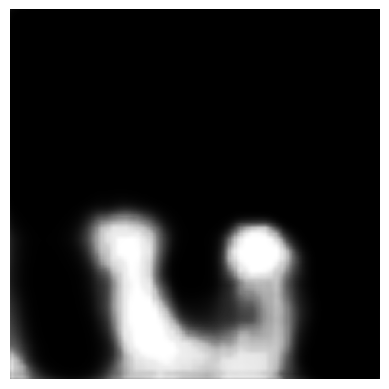

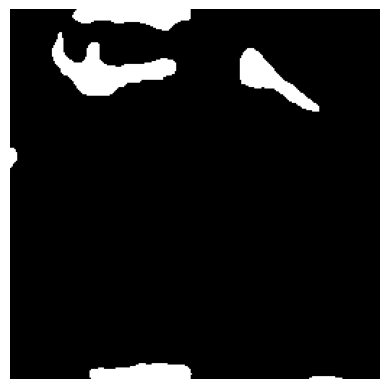

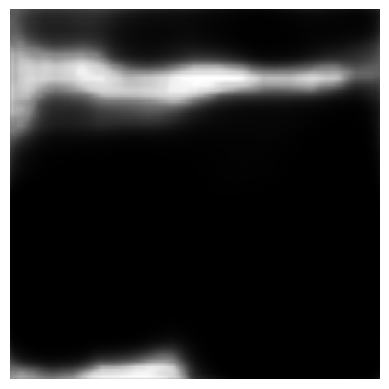

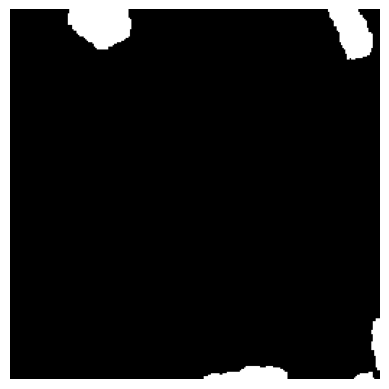

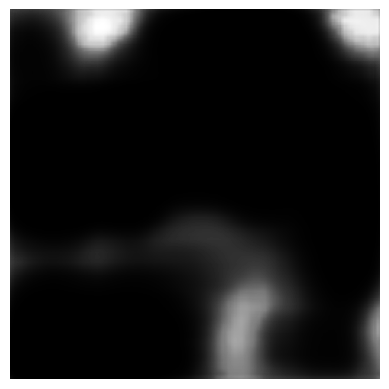

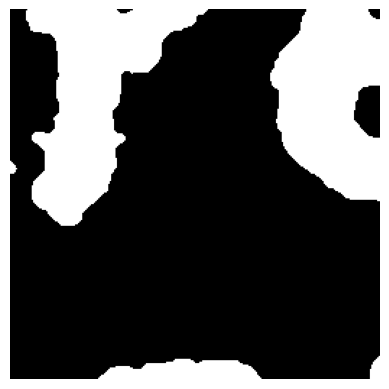

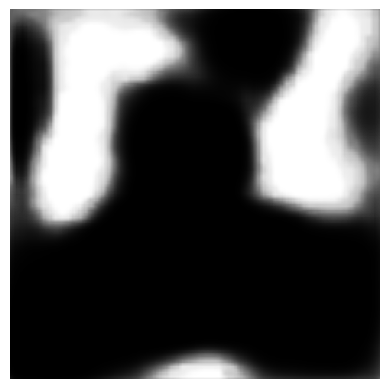

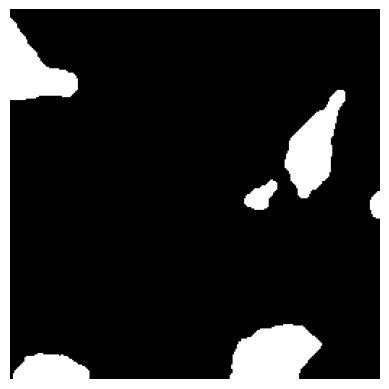

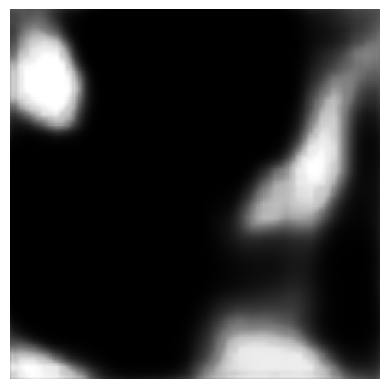

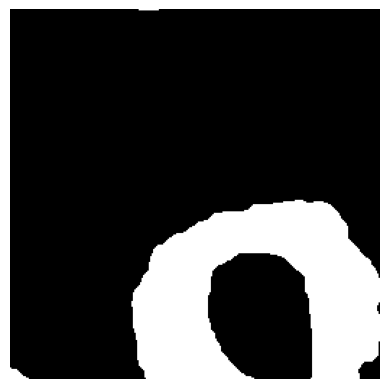

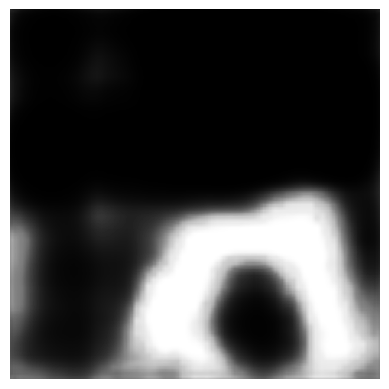

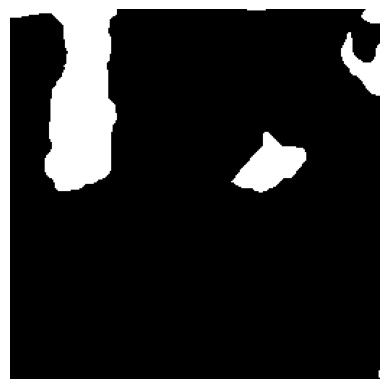

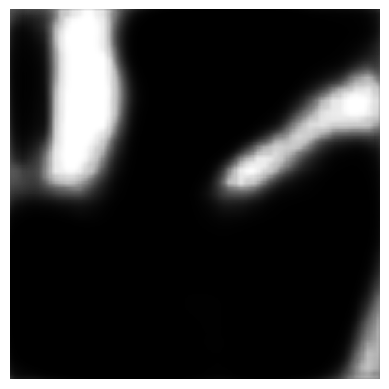

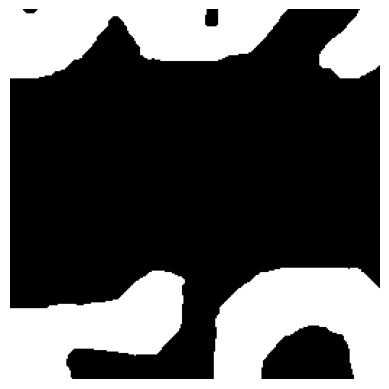

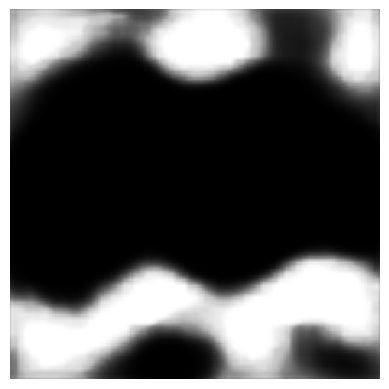

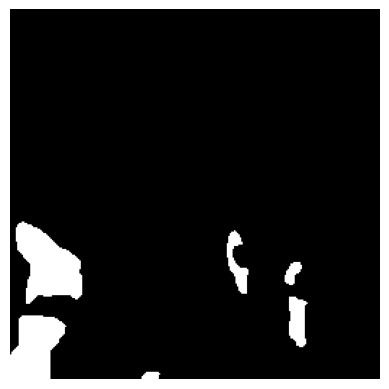

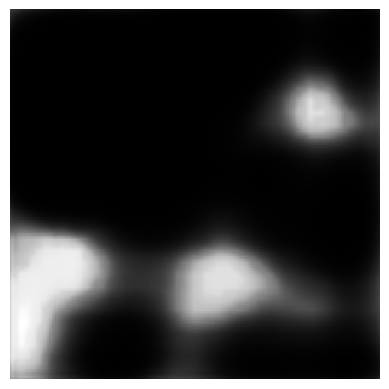

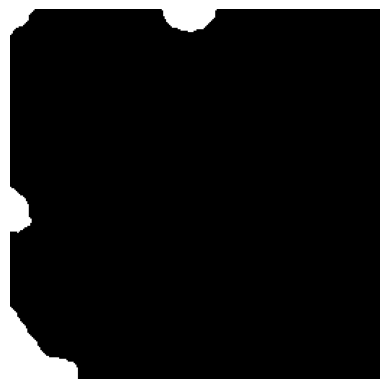

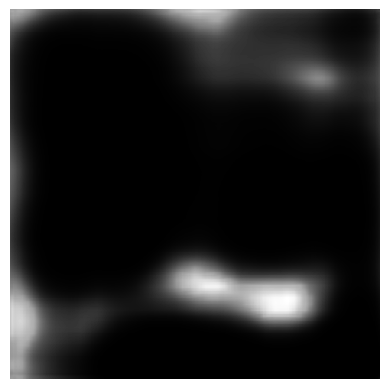

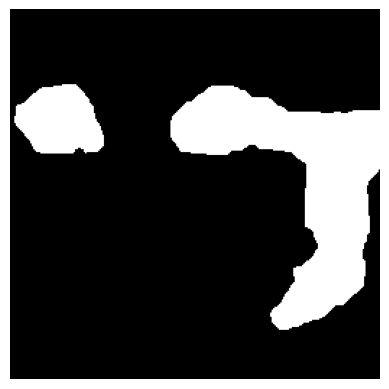

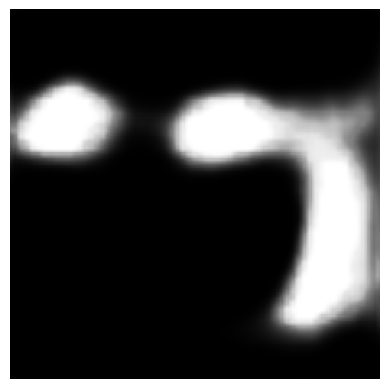

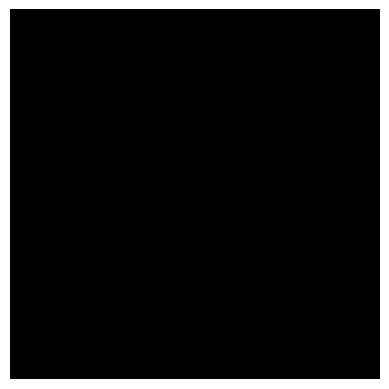

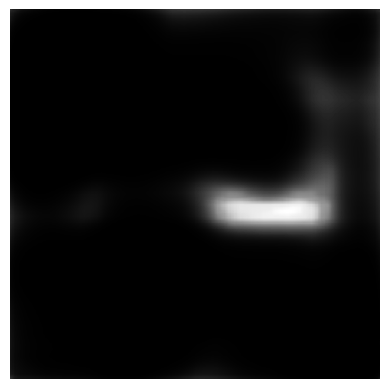

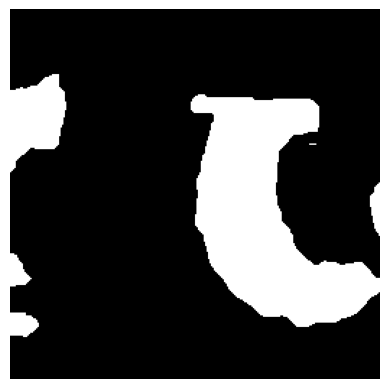

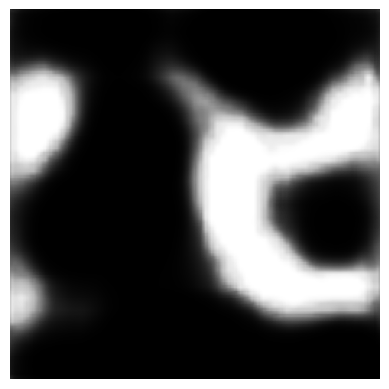

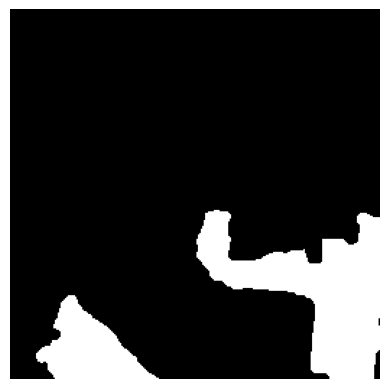

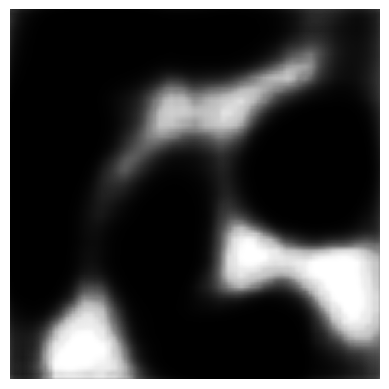

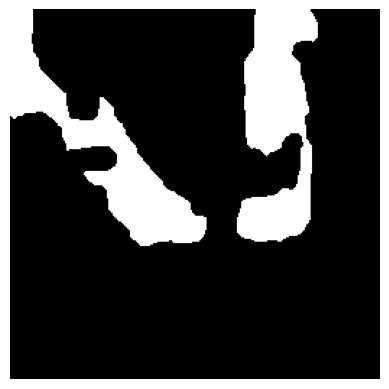

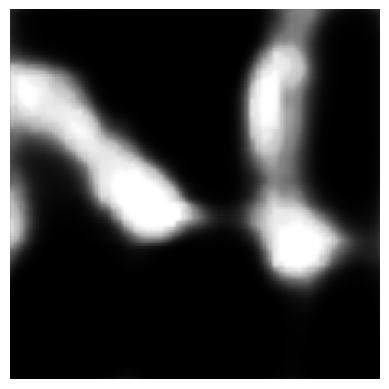

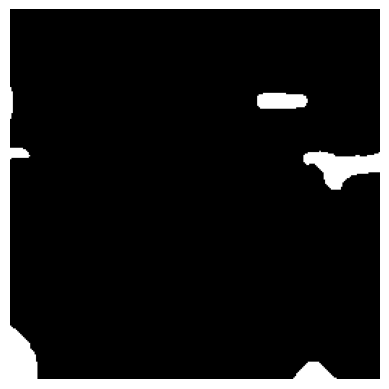

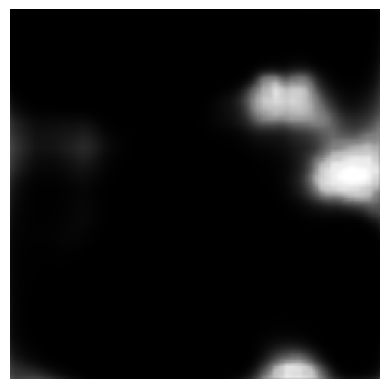

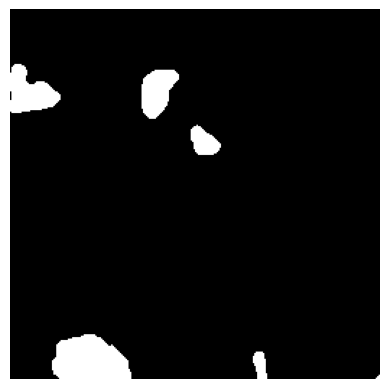

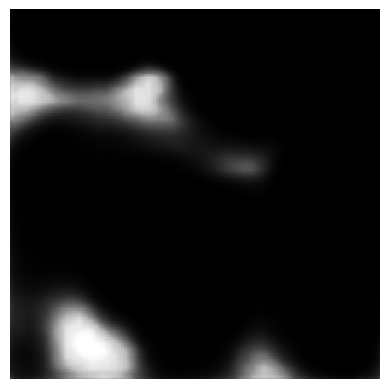

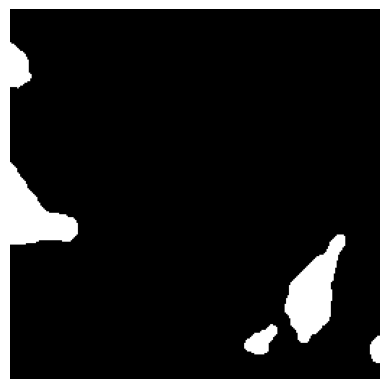

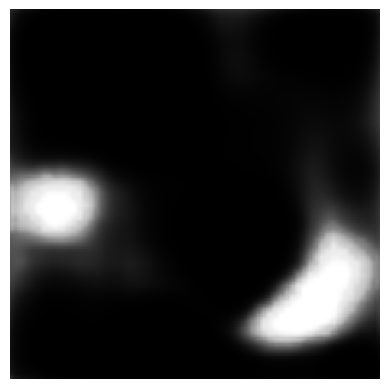

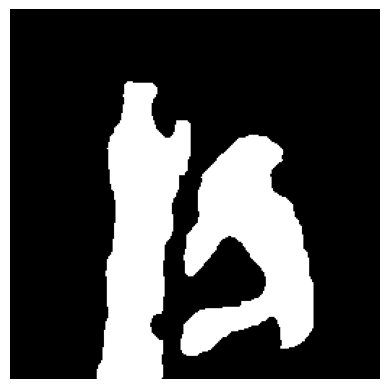

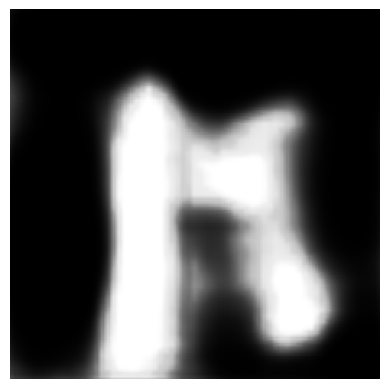

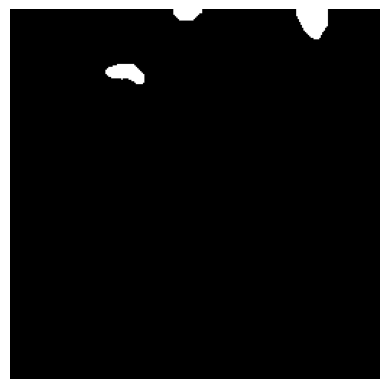

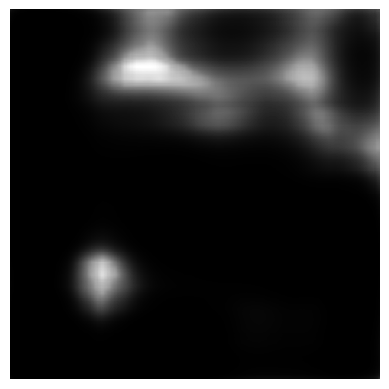

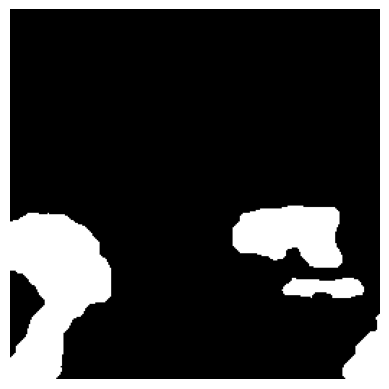

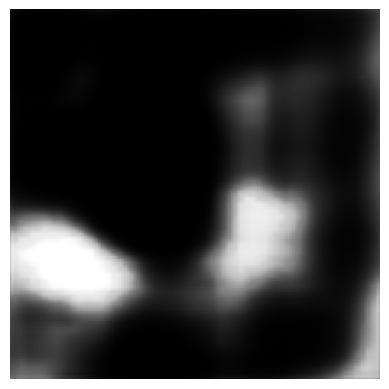

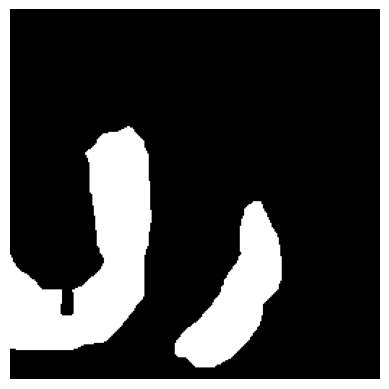

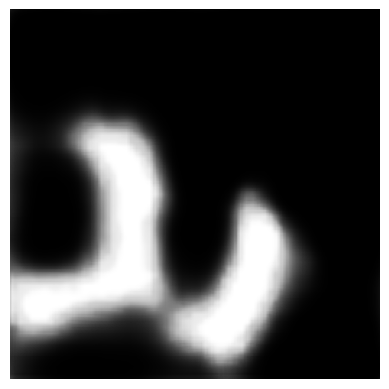

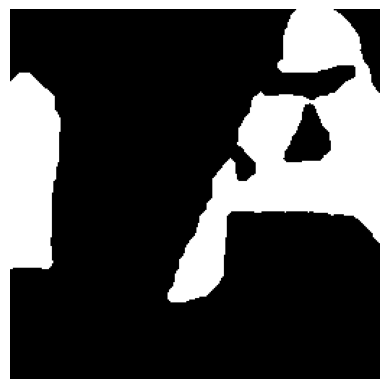

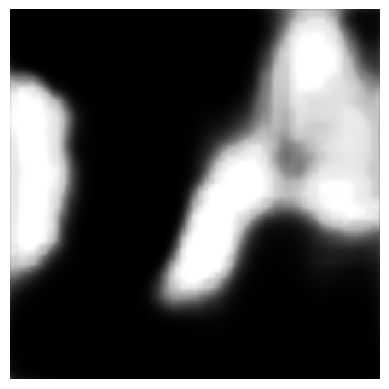

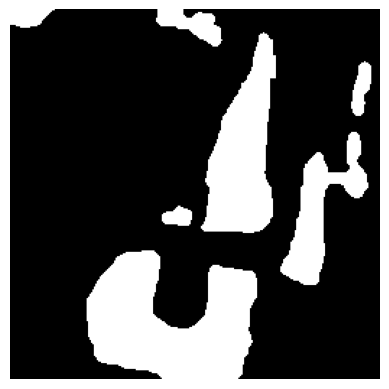

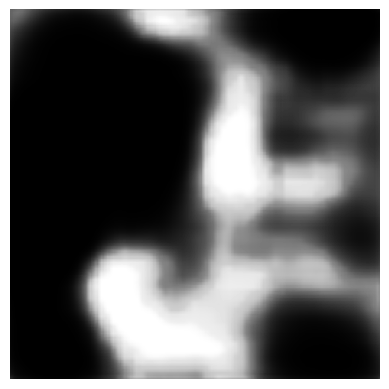

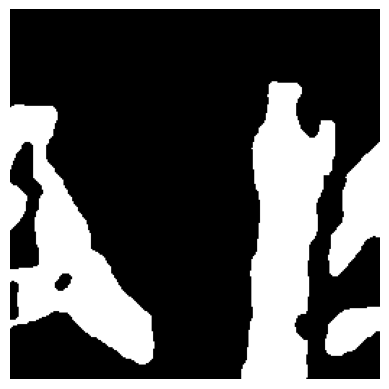

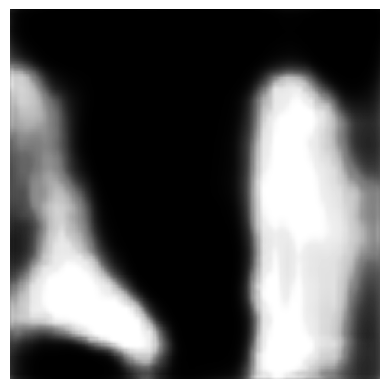

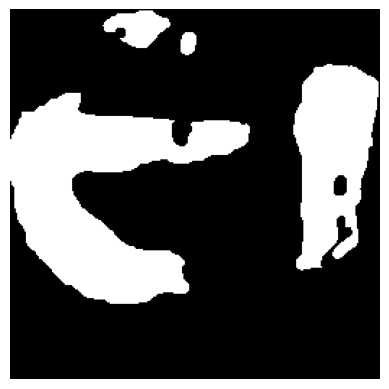

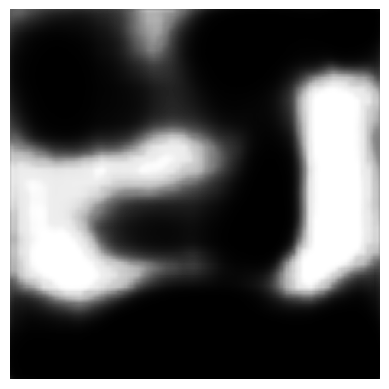

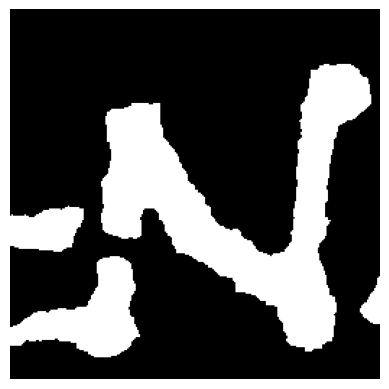

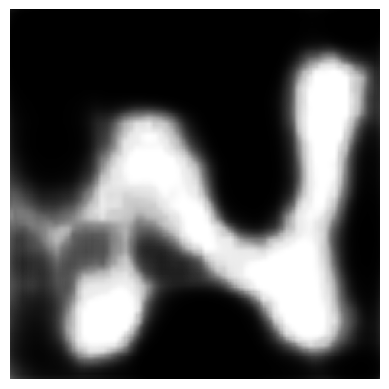

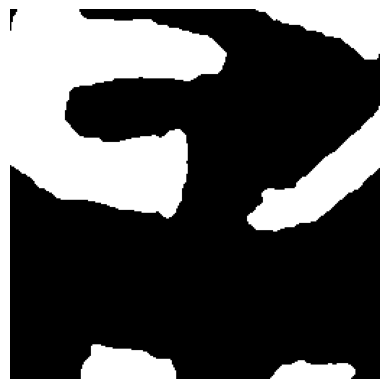

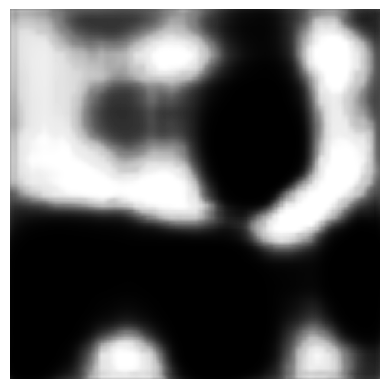

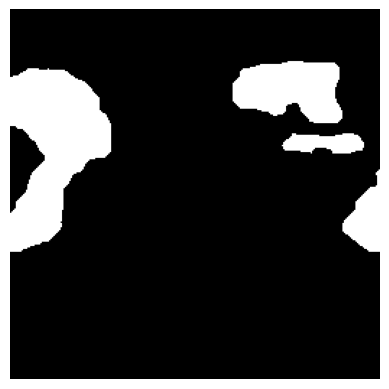

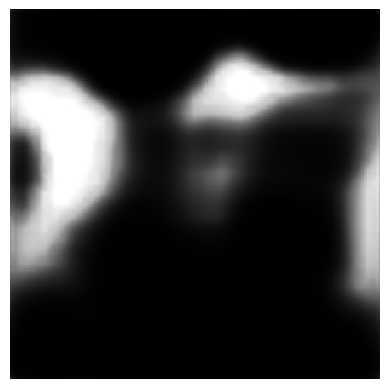

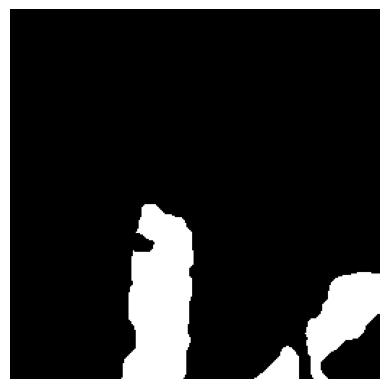

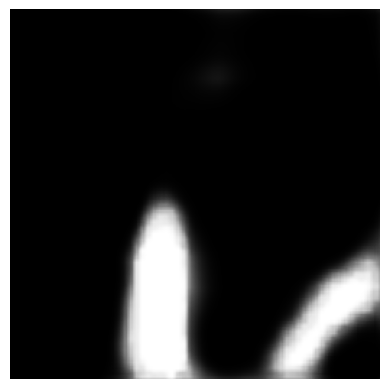

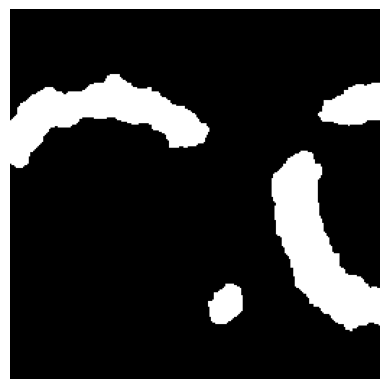

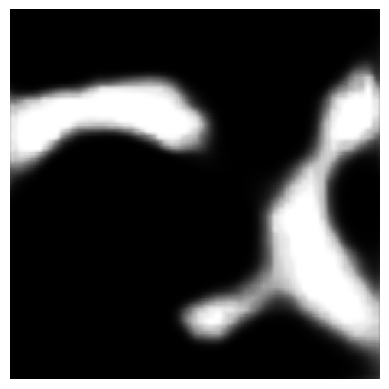

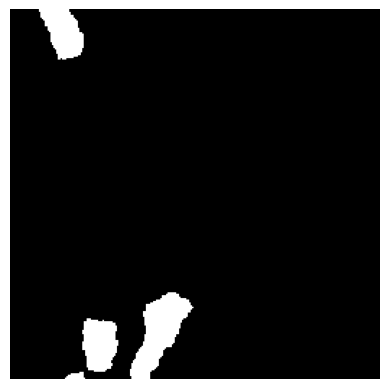

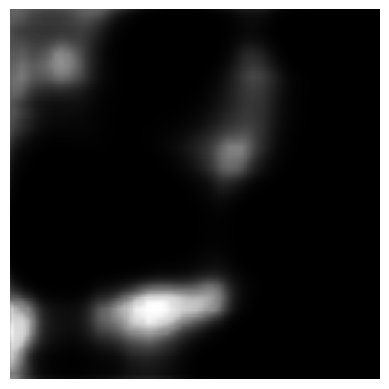

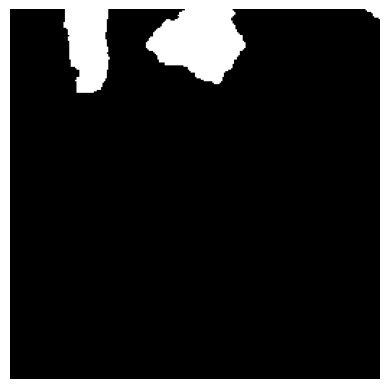

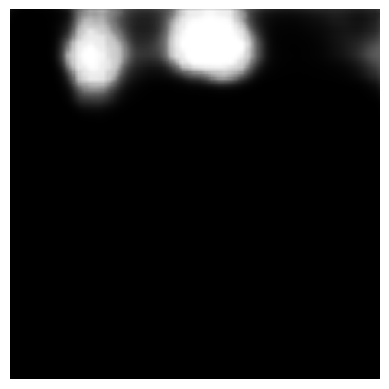

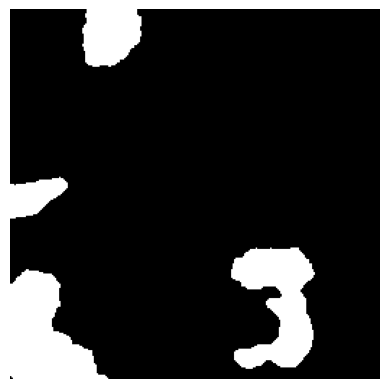

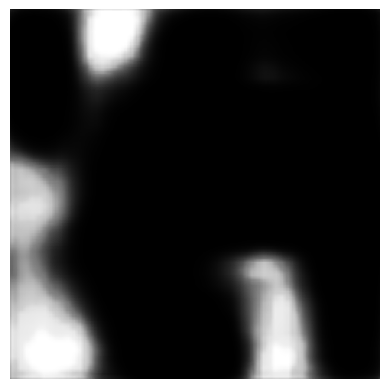

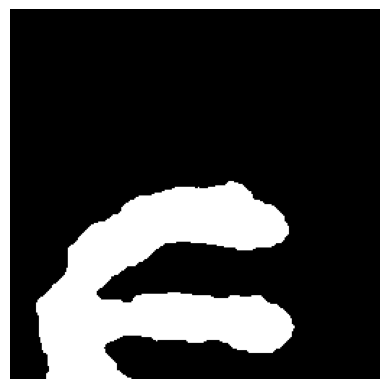

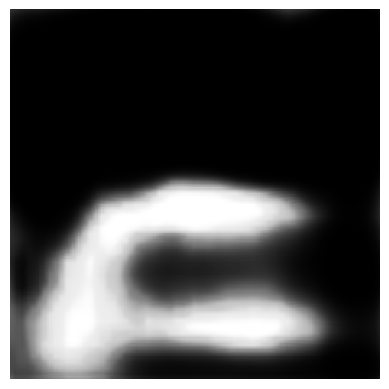

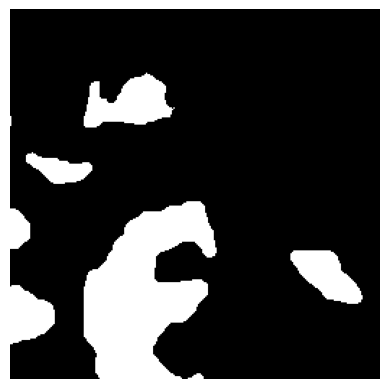

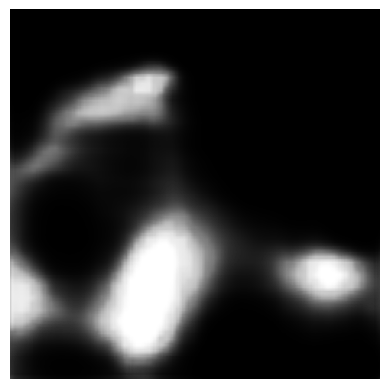

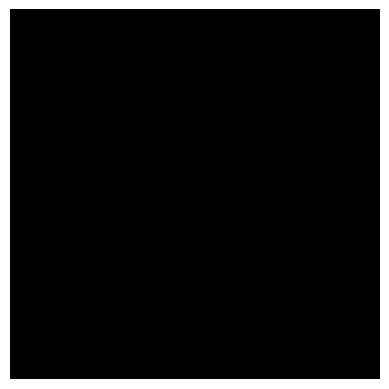

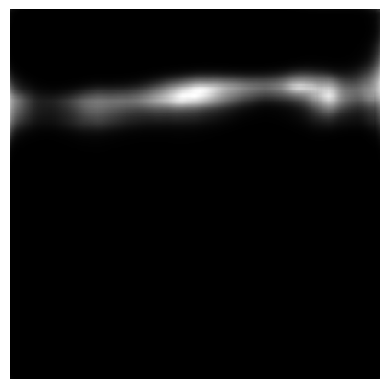

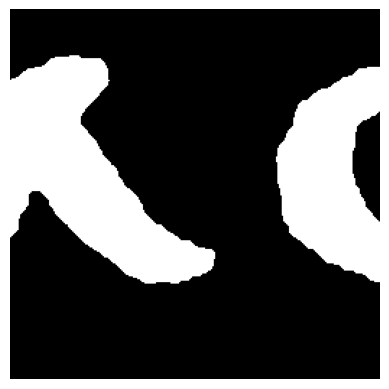

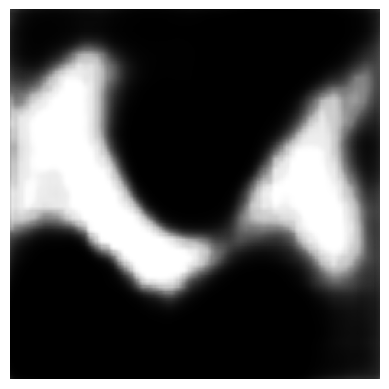

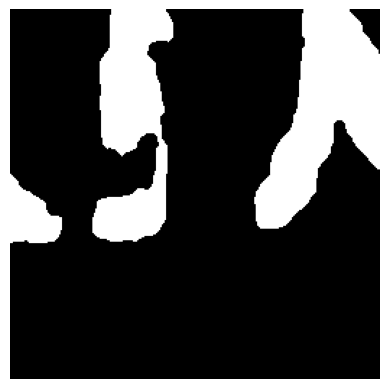

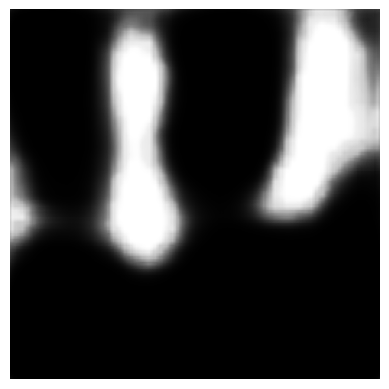

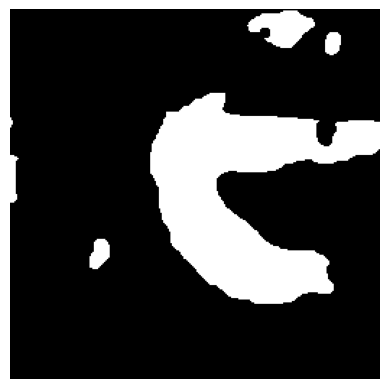

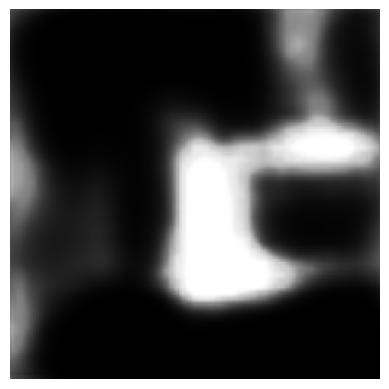

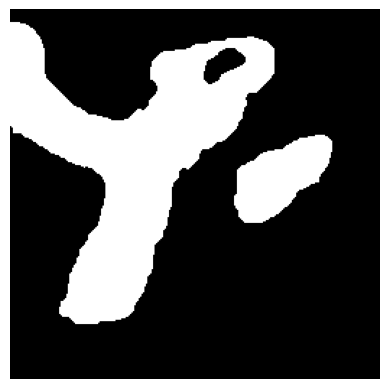

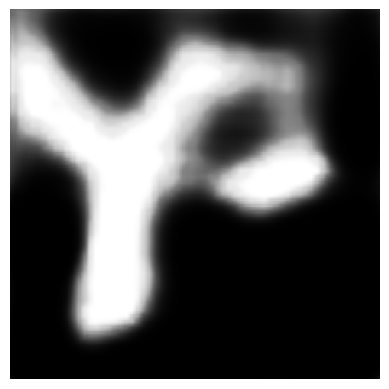

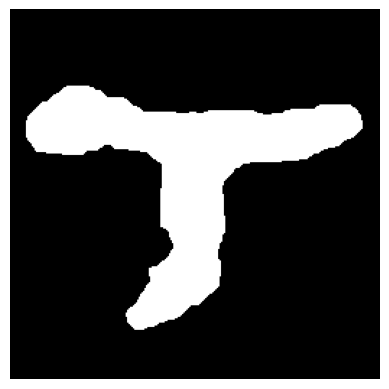

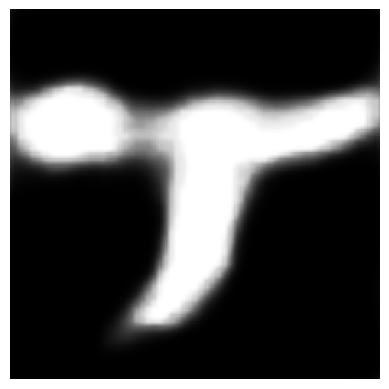

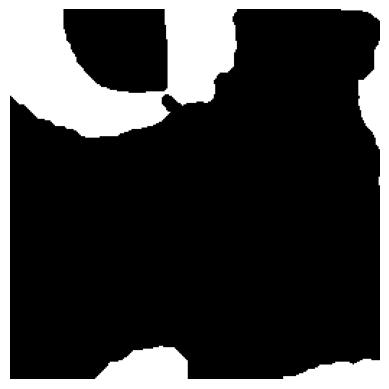

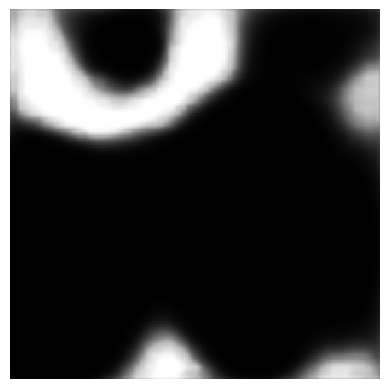

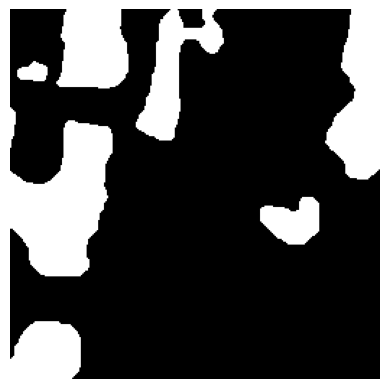

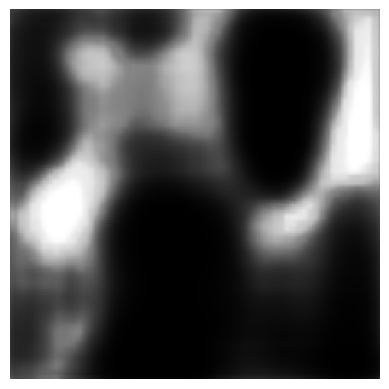

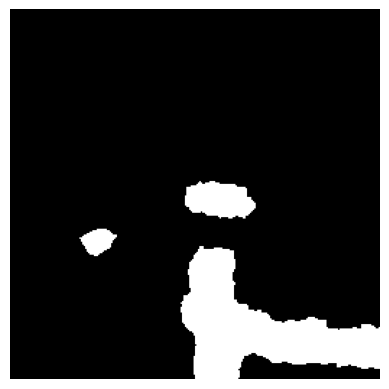

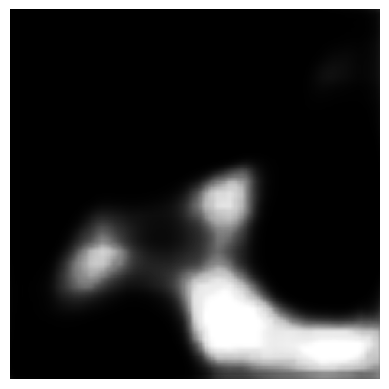

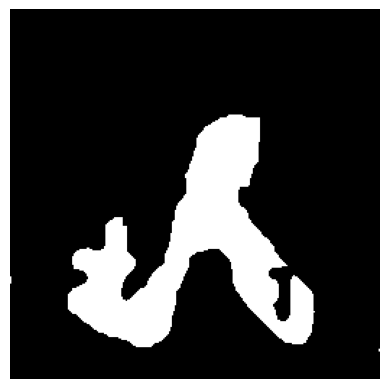

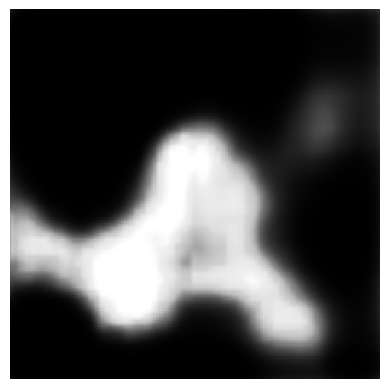

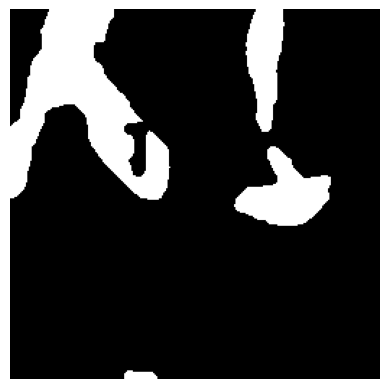

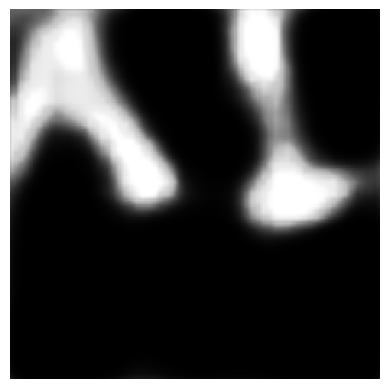

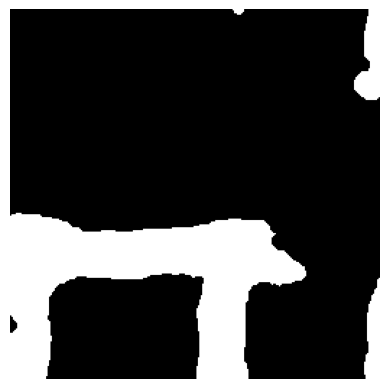

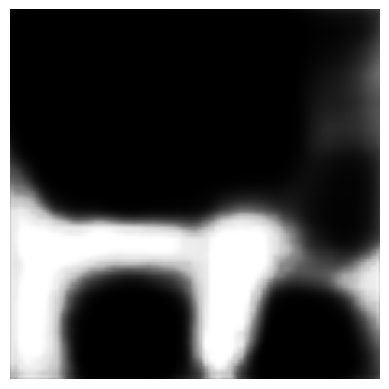

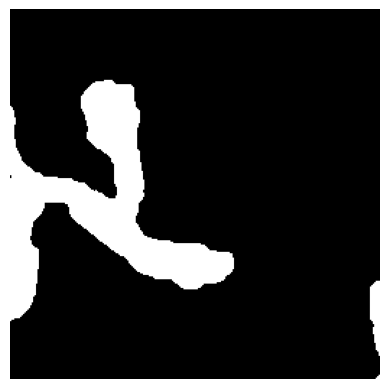

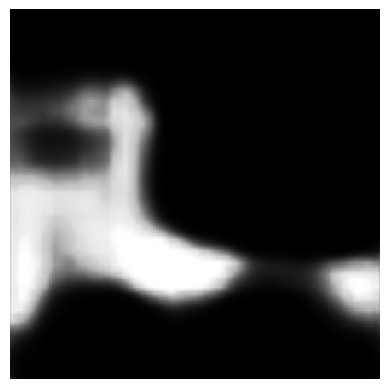

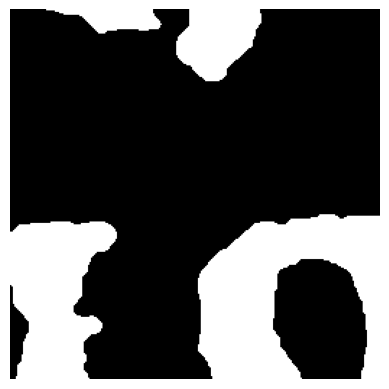

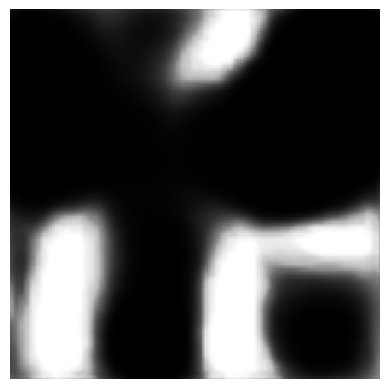

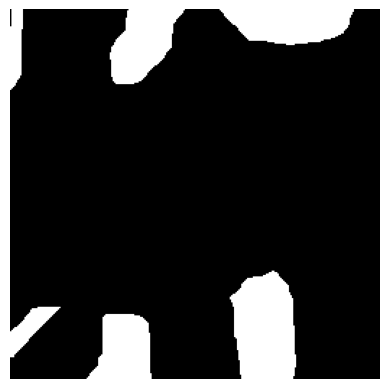

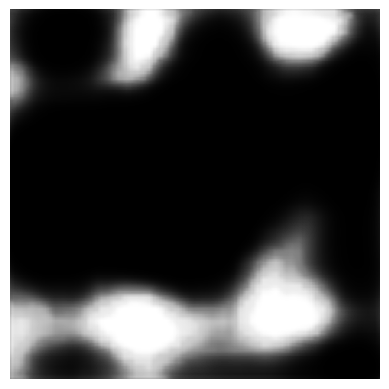

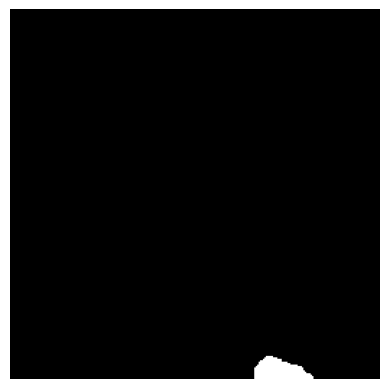

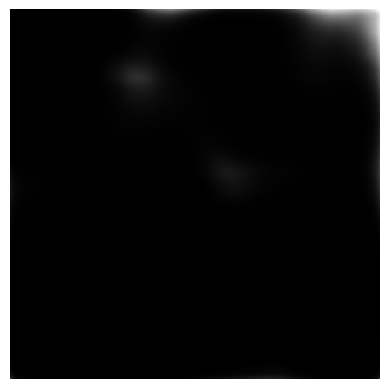

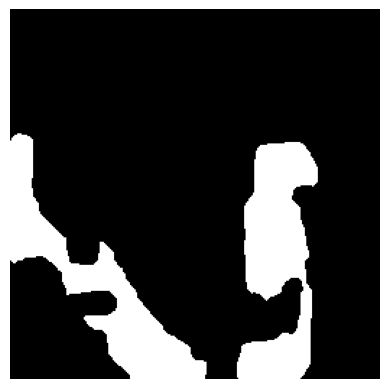

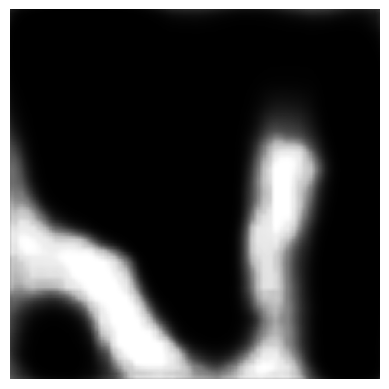

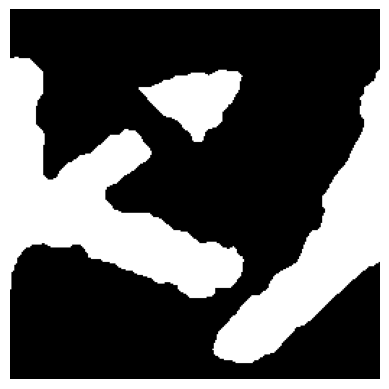

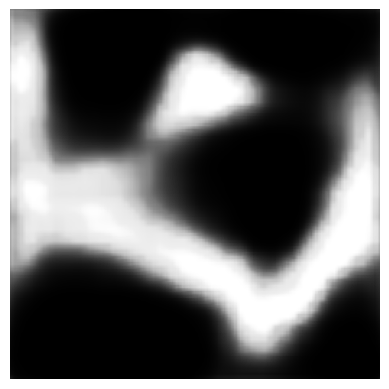

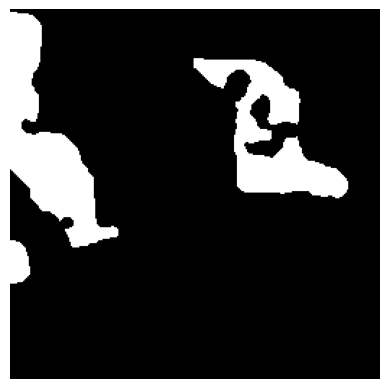

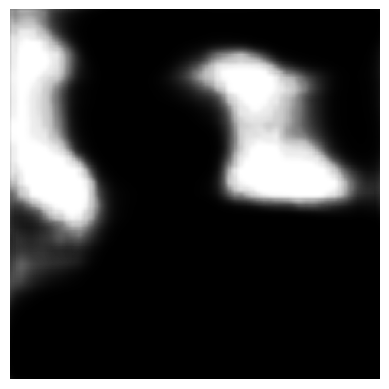

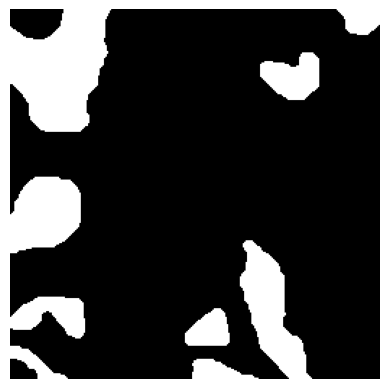

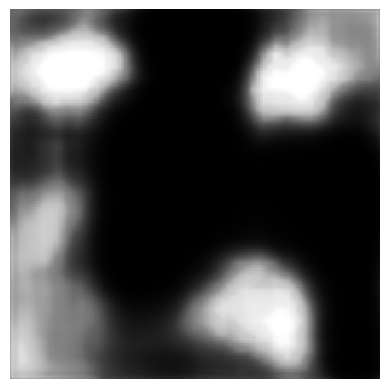

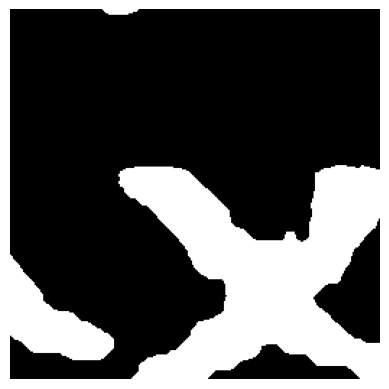

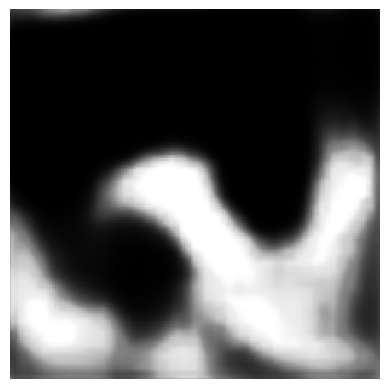

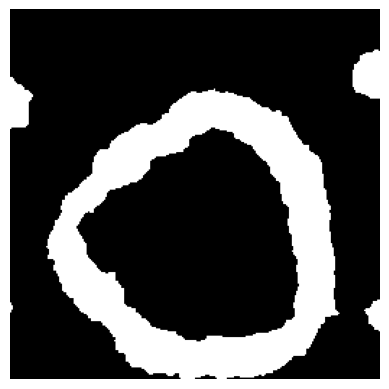

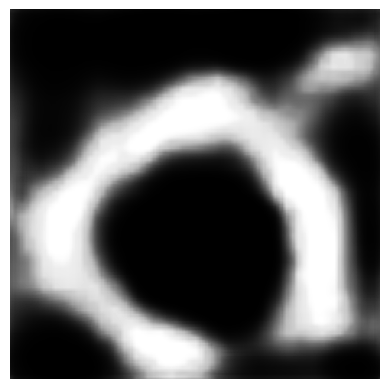

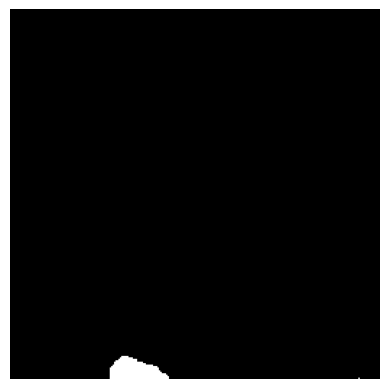

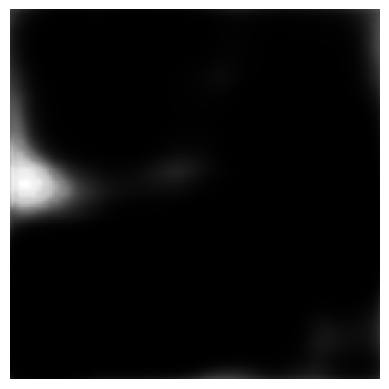

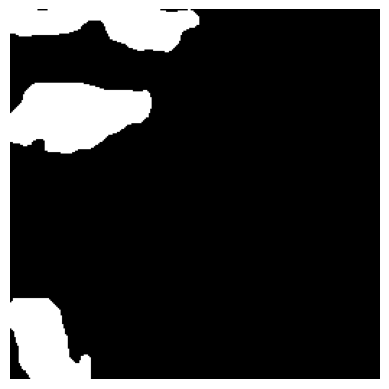

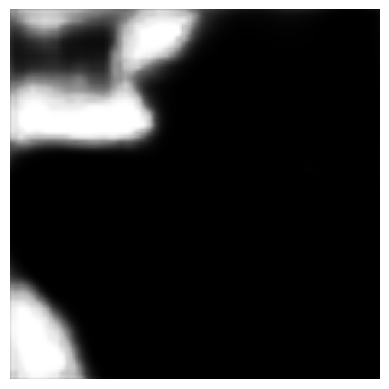

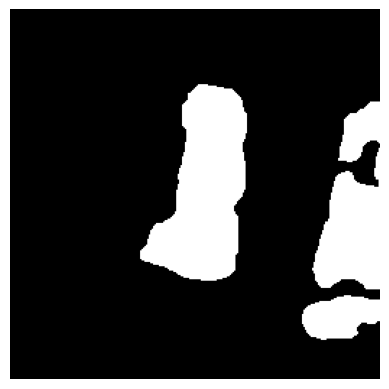

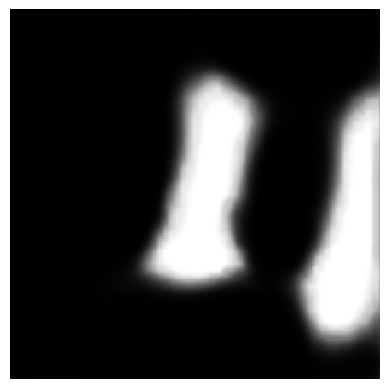

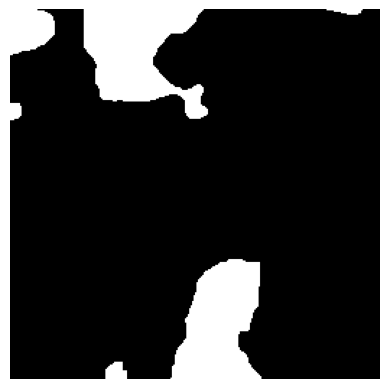

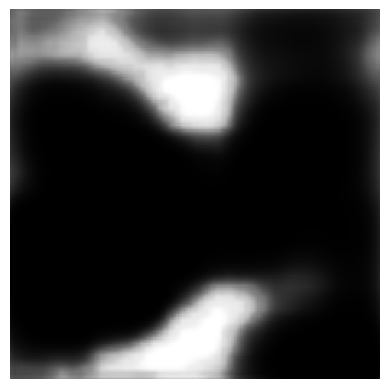

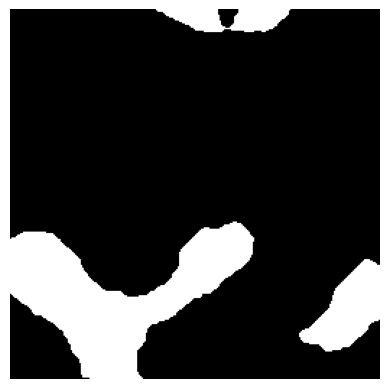

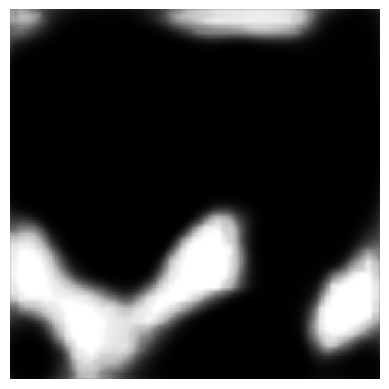

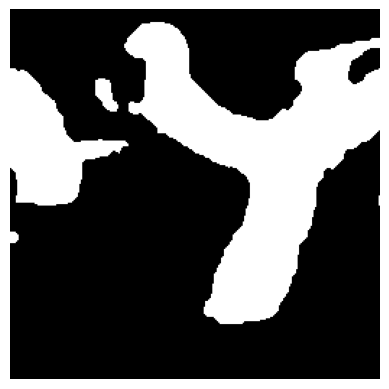

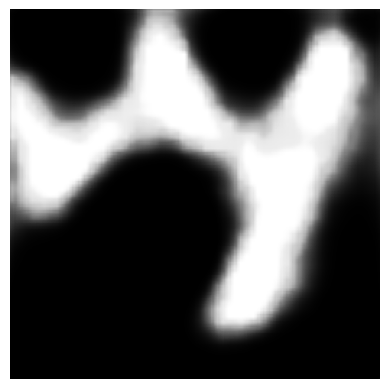

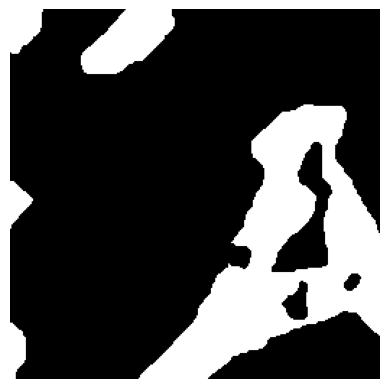

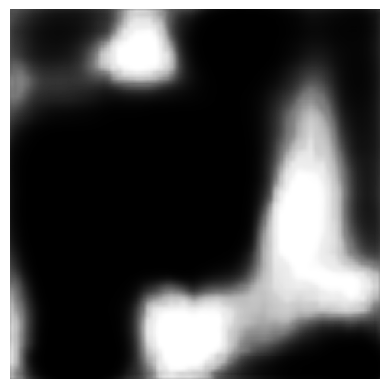

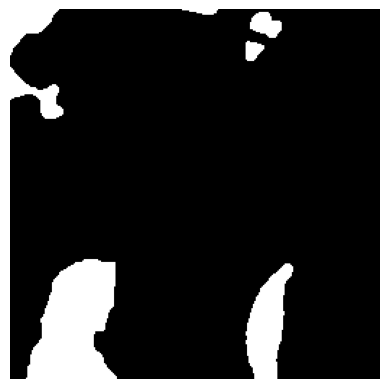

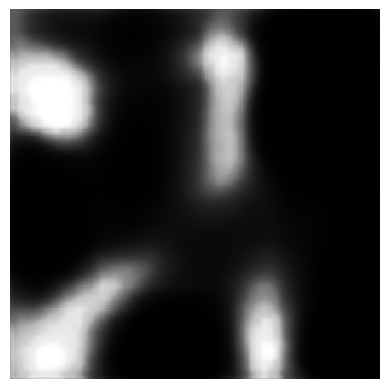

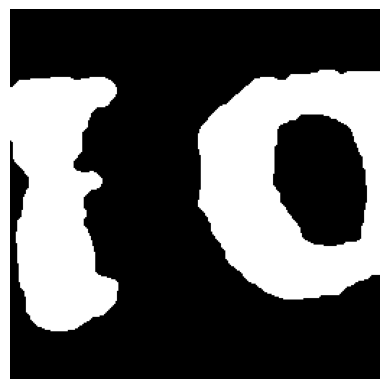

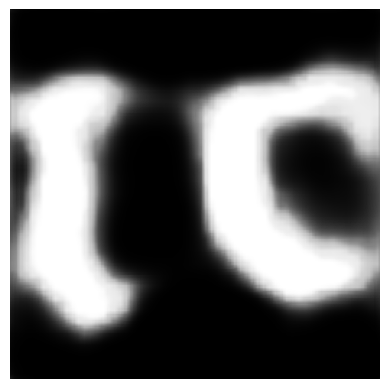

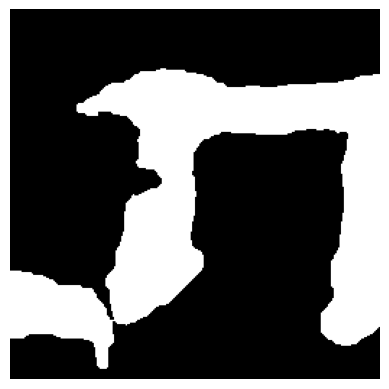

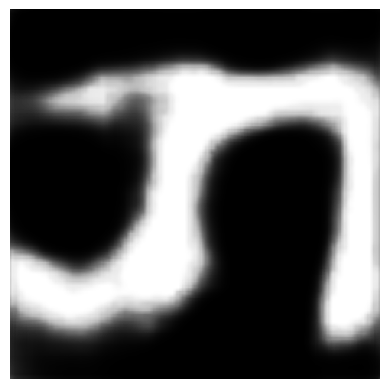

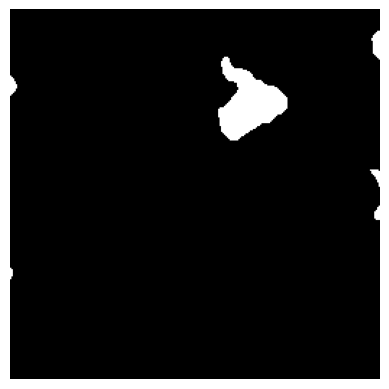

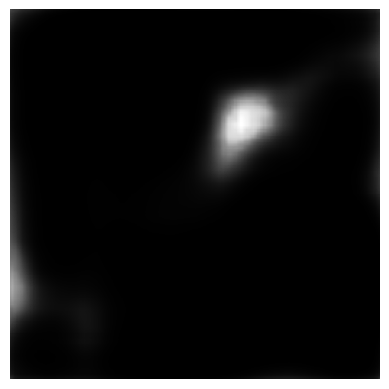

In [25]:
outputs_np = []
for result in results_test:
    # Convert the PyTorch tensor to a NumPy array
    outputs_np.append(result.cpu().numpy())

# Iterate over the outputs
for i in range(len(outputs_np)):
    output = outputs_np[i][0][0]

    # Display the output as an image
    plt.imshow(output, cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    plt.show()